# Assignment 2

### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import urllib.request

from dataclasses import dataclass
from torch.utils.data import DataLoader
from tqdm import tqdm

from lstm_solution import LSTM
from utils.wikitext2 import Wikitext2
from utils.torch_utils import seed_experiment, to_device
from utils.data_utils import save_logs
from run_exp_lstm import train, evaluate

import os


## Experiments

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularization, adding logs).

In [21]:
@dataclass
class Arguments:
    # Data
    data_folder: str = './data'
    batch_size: int = 16

    # Model
    model: str = 'lstm'  # [lstm, gpt1]
    embeddings: str = './data/embeddings.npz'
    layers: int = 1

    # Optimization
    optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
    epochs: int = 10
    lr: float = 1e-3
    momentum: float = 0.9
    weight_decay: float = 5e-4

    # Experiment
    exp_id: str = 'debug'
    log: bool = True
    log_dir: str = './logs'
    seed: int = 42

    # Miscellaneous
    num_workers: int = 2
    device: str = 'cuda'
    progress_bar: bool = False
    print_every: int = 10

The 6 configurations you need to run in Problem 1. Be careful that there is no discrepency between the configurations defined in `run_exp_lstm.py` and the ones below. In case there is a difference, the version from `run_exp_lstm.py` should be considered the ones to run.

In [22]:
# Note: if there is any discrepency with the configurations in run_exp_lstm.py, the
# version from run_exp_lstm.py should be the ones to use in Problem 1.
configs = {
  1: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='adam'),
  2: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  3: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='sgd'),
  4: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='momentum'),

  5: Arguments(model='lstm', layers=2, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  6: Arguments(model='lstm', layers=4, batch_size=16, log=True, epochs=10, optimizer='adamw')
}

In [4]:
def main(args):
    # Seed the experiment, for repeatability
    seed_experiment(args.seed)

    # Dataloaders
    train_dataset = Wikitext2(args.data_folder, split="train")
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
    )

    valid_dataset = Wikitext2(args.data_folder, split="validation")
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
    )

    test_dataset = Wikitext2(args.data_folder, split="test")
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
    )

    # Download the embeddings
    if not os.path.isfile(args.embeddings):
        print("No embedding file please place embedding.pkl in ./data")

    # Model
    if args.model == "lstm":
        model = LSTM.load_embeddings_from(
            args.embeddings, hidden_size=512, num_layers=args.layers
        )
    else:
        raise ValueError("Unknown model {0}".format(args.model))
    model.to(args.device)

    # Optimizer
    if args.optimizer == "adamw":
        optimizer = optim.AdamW(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "momentum":
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.lr,
            momentum=args.momentum,
            weight_decay=args.weight_decay,
        )

    print(
        f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
        f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
    )

    train_losses, valid_losses = [], []
    train_ppls, valid_ppls = [], []
    train_times, valid_times = [], []
    for epoch in range(args.epochs):
        
        tqdm.write(f"====== Epoch {epoch} ======>")

        loss, ppl, wall_time = train(epoch, model, train_dataloader, optimizer, args)
        train_losses.append(loss)
        train_ppls.append(ppl)
        train_times.append(wall_time)

        loss, ppl, wall_time = evaluate(epoch, model, valid_dataloader, args)
        valid_losses.append(loss)
        valid_ppls.append(ppl)
        valid_times.append(wall_time)

    test_loss, test_ppl, test_time = evaluate(
        epoch, model, test_dataloader, args, mode="test"
    )

    print(f"===== Best validation perplexity: {min(valid_ppls):.3f} =====>")

    return (
        train_losses,
        train_ppls,
        train_times,
        valid_losses,
        valid_ppls,
        valid_times,
        test_loss,
        test_ppl,
        test_time,
    )

In [5]:
args = configs[1]  # Run the first configuration
logs = main(args)
if args.log:
    save_logs(args, *logs)

Initialized LSTM model with 34107392 total parameters, of which 3019520 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.60759
[TRAIN] Epoch: 0, Iter: 10, Loss: 8.51249
[TRAIN] Epoch: 0, Iter: 20, Loss: 7.83956
[TRAIN] Epoch: 0, Iter: 30, Loss: 7.61677
[TRAIN] Epoch: 0, Iter: 40, Loss: 7.55537
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.57466
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.42349
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.38460
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.25695
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.32303
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.19864
[TRAIN] Epoch: 0, Iter: 110, Loss: 6.99711
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.16824
[TRAIN] Epoch: 0, Iter: 130, Loss: 6.89282
[TRAIN] Epoch: 0, Iter: 140, Loss: 6.88982
[TRAIN] Epoch: 0, Iter: 150, Loss: 6.69845
[TRAIN] Epoch: 0, Iter: 160, Loss: 6.87716
[TRAIN] Epoch: 0, Iter: 170, Loss: 6.82899
[TRAIN] Epoch: 0, Iter: 180, Loss: 6.60973
[TRAIN] Epoch: 0, Iter: 190, Loss: 6.67359
[TRAIN] Epoch: 0, Iter: 200, Loss: 6.571

[TRAIN] Epoch: 2, Iter: 560, Loss: 5.03635
[TRAIN] Epoch: 2, Iter: 570, Loss: 5.14074
== [TRAIN] Epoch: 2, Perplexity: 205.904 ==>
[VAL] Epoch: 2, Iter: 0, Loss: 5.25633
[VAL] Epoch: 2, Iter: 10, Loss: 5.36088
[VAL] Epoch: 2, Iter: 20, Loss: 5.47581
[VAL] Epoch: 2, Iter: 30, Loss: 5.44062
[VAL] Epoch: 2, Iter: 40, Loss: 5.21125
[VAL] Epoch: 2, Iter: 50, Loss: 5.09733
=== [VAL] Epoch: 2, Iter: 59, Perplexity: 199.774 ===>
====== Epoch 3 ======>
[TRAIN] Epoch: 3, Iter: 0, Loss: 5.14731
[TRAIN] Epoch: 3, Iter: 10, Loss: 5.26199
[TRAIN] Epoch: 3, Iter: 20, Loss: 5.08635
[TRAIN] Epoch: 3, Iter: 30, Loss: 5.01310
[TRAIN] Epoch: 3, Iter: 40, Loss: 5.12836
[TRAIN] Epoch: 3, Iter: 50, Loss: 5.13084
[TRAIN] Epoch: 3, Iter: 60, Loss: 5.17041
[TRAIN] Epoch: 3, Iter: 70, Loss: 5.09189
[TRAIN] Epoch: 3, Iter: 80, Loss: 5.26464
[TRAIN] Epoch: 3, Iter: 90, Loss: 5.09582
[TRAIN] Epoch: 3, Iter: 100, Loss: 5.24372
[TRAIN] Epoch: 3, Iter: 110, Loss: 5.13456
[TRAIN] Epoch: 3, Iter: 120, Loss: 5.16135
[TRA

[TRAIN] Epoch: 5, Iter: 490, Loss: 4.64190
[TRAIN] Epoch: 5, Iter: 500, Loss: 4.77957
[TRAIN] Epoch: 5, Iter: 510, Loss: 4.69491
[TRAIN] Epoch: 5, Iter: 520, Loss: 4.87426
[TRAIN] Epoch: 5, Iter: 530, Loss: 4.78816
[TRAIN] Epoch: 5, Iter: 540, Loss: 4.69989
[TRAIN] Epoch: 5, Iter: 550, Loss: 4.66975
[TRAIN] Epoch: 5, Iter: 560, Loss: 4.84770
[TRAIN] Epoch: 5, Iter: 570, Loss: 4.66178
== [TRAIN] Epoch: 5, Perplexity: 118.357 ==>
[VAL] Epoch: 5, Iter: 0, Loss: 4.89904
[VAL] Epoch: 5, Iter: 10, Loss: 5.11861
[VAL] Epoch: 5, Iter: 20, Loss: 5.18852
[VAL] Epoch: 5, Iter: 30, Loss: 5.23456
[VAL] Epoch: 5, Iter: 40, Loss: 4.95054
[VAL] Epoch: 5, Iter: 50, Loss: 4.86654
=== [VAL] Epoch: 5, Iter: 59, Perplexity: 155.429 ===>
====== Epoch 6 ======>
[TRAIN] Epoch: 6, Iter: 0, Loss: 4.61598
[TRAIN] Epoch: 6, Iter: 10, Loss: 4.65482
[TRAIN] Epoch: 6, Iter: 20, Loss: 4.95149
[TRAIN] Epoch: 6, Iter: 30, Loss: 4.80126
[TRAIN] Epoch: 6, Iter: 40, Loss: 4.56892
[TRAIN] Epoch: 6, Iter: 50, Loss: 4.72025


[TRAIN] Epoch: 8, Iter: 420, Loss: 4.53758
[TRAIN] Epoch: 8, Iter: 430, Loss: 4.44561
[TRAIN] Epoch: 8, Iter: 440, Loss: 4.54453
[TRAIN] Epoch: 8, Iter: 450, Loss: 4.56582
[TRAIN] Epoch: 8, Iter: 460, Loss: 4.67998
[TRAIN] Epoch: 8, Iter: 470, Loss: 4.48166
[TRAIN] Epoch: 8, Iter: 480, Loss: 4.69343
[TRAIN] Epoch: 8, Iter: 490, Loss: 4.52163
[TRAIN] Epoch: 8, Iter: 500, Loss: 4.48295
[TRAIN] Epoch: 8, Iter: 510, Loss: 4.66919
[TRAIN] Epoch: 8, Iter: 520, Loss: 4.57634
[TRAIN] Epoch: 8, Iter: 530, Loss: 4.49076
[TRAIN] Epoch: 8, Iter: 540, Loss: 4.31121
[TRAIN] Epoch: 8, Iter: 550, Loss: 4.55559
[TRAIN] Epoch: 8, Iter: 560, Loss: 4.53660
[TRAIN] Epoch: 8, Iter: 570, Loss: 4.44221
== [TRAIN] Epoch: 8, Perplexity: 87.309 ==>
[VAL] Epoch: 8, Iter: 0, Loss: 4.78766
[VAL] Epoch: 8, Iter: 10, Loss: 5.06411
[VAL] Epoch: 8, Iter: 20, Loss: 5.11781
[VAL] Epoch: 8, Iter: 30, Loss: 5.20408
[VAL] Epoch: 8, Iter: 40, Loss: 4.87505
[VAL] Epoch: 8, Iter: 50, Loss: 4.79079
=== [VAL] Epoch: 8, Iter: 59,

In [6]:
args = configs[2]
logs = main(args)
if args.log:
    save_logs(args, *logs)

Initialized LSTM model with 34107392 total parameters, of which 3019520 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.60759
[TRAIN] Epoch: 0, Iter: 10, Loss: 8.51249
[TRAIN] Epoch: 0, Iter: 20, Loss: 7.83956
[TRAIN] Epoch: 0, Iter: 30, Loss: 7.61677
[TRAIN] Epoch: 0, Iter: 40, Loss: 7.55535
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.57463
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.42347
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.38456
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.25691
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.32303
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.19875
[TRAIN] Epoch: 0, Iter: 110, Loss: 6.99723
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.16871
[TRAIN] Epoch: 0, Iter: 130, Loss: 6.89350
[TRAIN] Epoch: 0, Iter: 140, Loss: 6.89058
[TRAIN] Epoch: 0, Iter: 150, Loss: 6.69992
[TRAIN] Epoch: 0, Iter: 160, Loss: 6.87709
[TRAIN] Epoch: 0, Iter: 170, Loss: 6.83115
[TRAIN] Epoch: 0, Iter: 180, Loss: 6.61158
[TRAIN] Epoch: 0, Iter: 190, Loss: 6.67511
[TRAIN] Epoch: 0, Iter: 200, Loss: 6.570

[TRAIN] Epoch: 2, Iter: 560, Loss: 5.07371
[TRAIN] Epoch: 2, Iter: 570, Loss: 5.16164
== [TRAIN] Epoch: 2, Perplexity: 211.264 ==>
[VAL] Epoch: 2, Iter: 0, Loss: 5.28472
[VAL] Epoch: 2, Iter: 10, Loss: 5.39943
[VAL] Epoch: 2, Iter: 20, Loss: 5.48730
[VAL] Epoch: 2, Iter: 30, Loss: 5.47197
[VAL] Epoch: 2, Iter: 40, Loss: 5.23009
[VAL] Epoch: 2, Iter: 50, Loss: 5.12107
=== [VAL] Epoch: 2, Iter: 59, Perplexity: 204.615 ===>
====== Epoch 3 ======>
[TRAIN] Epoch: 3, Iter: 0, Loss: 5.19263
[TRAIN] Epoch: 3, Iter: 10, Loss: 5.29272
[TRAIN] Epoch: 3, Iter: 20, Loss: 5.12021
[TRAIN] Epoch: 3, Iter: 30, Loss: 5.03523
[TRAIN] Epoch: 3, Iter: 40, Loss: 5.15205
[TRAIN] Epoch: 3, Iter: 50, Loss: 5.12628
[TRAIN] Epoch: 3, Iter: 60, Loss: 5.20398
[TRAIN] Epoch: 3, Iter: 70, Loss: 5.11446
[TRAIN] Epoch: 3, Iter: 80, Loss: 5.29170
[TRAIN] Epoch: 3, Iter: 90, Loss: 5.12317
[TRAIN] Epoch: 3, Iter: 100, Loss: 5.27933
[TRAIN] Epoch: 3, Iter: 110, Loss: 5.16672
[TRAIN] Epoch: 3, Iter: 120, Loss: 5.19916
[TRA

[TRAIN] Epoch: 5, Iter: 490, Loss: 4.64877
[TRAIN] Epoch: 5, Iter: 500, Loss: 4.77597
[TRAIN] Epoch: 5, Iter: 510, Loss: 4.71214
[TRAIN] Epoch: 5, Iter: 520, Loss: 4.88682
[TRAIN] Epoch: 5, Iter: 530, Loss: 4.79447
[TRAIN] Epoch: 5, Iter: 540, Loss: 4.70261
[TRAIN] Epoch: 5, Iter: 550, Loss: 4.66607
[TRAIN] Epoch: 5, Iter: 560, Loss: 4.86013
[TRAIN] Epoch: 5, Iter: 570, Loss: 4.67663
== [TRAIN] Epoch: 5, Perplexity: 119.821 ==>
[VAL] Epoch: 5, Iter: 0, Loss: 4.93528
[VAL] Epoch: 5, Iter: 10, Loss: 5.13914
[VAL] Epoch: 5, Iter: 20, Loss: 5.17790
[VAL] Epoch: 5, Iter: 30, Loss: 5.23641
[VAL] Epoch: 5, Iter: 40, Loss: 4.96135
[VAL] Epoch: 5, Iter: 50, Loss: 4.89485
=== [VAL] Epoch: 5, Iter: 59, Perplexity: 157.506 ===>
====== Epoch 6 ======>
[TRAIN] Epoch: 6, Iter: 0, Loss: 4.62144
[TRAIN] Epoch: 6, Iter: 10, Loss: 4.68307
[TRAIN] Epoch: 6, Iter: 20, Loss: 4.97394
[TRAIN] Epoch: 6, Iter: 30, Loss: 4.81513
[TRAIN] Epoch: 6, Iter: 40, Loss: 4.57770
[TRAIN] Epoch: 6, Iter: 50, Loss: 4.72932


[TRAIN] Epoch: 8, Iter: 420, Loss: 4.53830
[TRAIN] Epoch: 8, Iter: 430, Loss: 4.46810
[TRAIN] Epoch: 8, Iter: 440, Loss: 4.54095
[TRAIN] Epoch: 8, Iter: 450, Loss: 4.56615
[TRAIN] Epoch: 8, Iter: 460, Loss: 4.67881
[TRAIN] Epoch: 8, Iter: 470, Loss: 4.46866
[TRAIN] Epoch: 8, Iter: 480, Loss: 4.69372
[TRAIN] Epoch: 8, Iter: 490, Loss: 4.52126
[TRAIN] Epoch: 8, Iter: 500, Loss: 4.45656
[TRAIN] Epoch: 8, Iter: 510, Loss: 4.68999
[TRAIN] Epoch: 8, Iter: 520, Loss: 4.57801
[TRAIN] Epoch: 8, Iter: 530, Loss: 4.50061
[TRAIN] Epoch: 8, Iter: 540, Loss: 4.28723
[TRAIN] Epoch: 8, Iter: 550, Loss: 4.57652
[TRAIN] Epoch: 8, Iter: 560, Loss: 4.53377
[TRAIN] Epoch: 8, Iter: 570, Loss: 4.46876
== [TRAIN] Epoch: 8, Perplexity: 87.671 ==>
[VAL] Epoch: 8, Iter: 0, Loss: 4.80729
[VAL] Epoch: 8, Iter: 10, Loss: 5.05226
[VAL] Epoch: 8, Iter: 20, Loss: 5.08807
[VAL] Epoch: 8, Iter: 30, Loss: 5.20995
[VAL] Epoch: 8, Iter: 40, Loss: 4.86109
[VAL] Epoch: 8, Iter: 50, Loss: 4.79976
=== [VAL] Epoch: 8, Iter: 59,

In [7]:
args = configs[3]
logs = main(args)
if args.log:
    save_logs(args, *logs)

Initialized LSTM model with 34107392 total parameters, of which 3019520 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.60759
[TRAIN] Epoch: 0, Iter: 10, Loss: 10.60043
[TRAIN] Epoch: 0, Iter: 20, Loss: 10.59470
[TRAIN] Epoch: 0, Iter: 30, Loss: 10.58981
[TRAIN] Epoch: 0, Iter: 40, Loss: 10.58366
[TRAIN] Epoch: 0, Iter: 50, Loss: 10.57872
[TRAIN] Epoch: 0, Iter: 60, Loss: 10.57168
[TRAIN] Epoch: 0, Iter: 70, Loss: 10.56722
[TRAIN] Epoch: 0, Iter: 80, Loss: 10.56236
[TRAIN] Epoch: 0, Iter: 90, Loss: 10.55735
[TRAIN] Epoch: 0, Iter: 100, Loss: 10.55134
[TRAIN] Epoch: 0, Iter: 110, Loss: 10.54614
[TRAIN] Epoch: 0, Iter: 120, Loss: 10.54164
[TRAIN] Epoch: 0, Iter: 130, Loss: 10.53424
[TRAIN] Epoch: 0, Iter: 140, Loss: 10.52969
[TRAIN] Epoch: 0, Iter: 150, Loss: 10.52247
[TRAIN] Epoch: 0, Iter: 160, Loss: 10.52107
[TRAIN] Epoch: 0, Iter: 170, Loss: 10.51572
[TRAIN] Epoch: 0, Iter: 180, Loss: 10.50896
[TRAIN] Epoch: 0, Iter: 190, Loss: 10.50789
[TRAIN] Epoch: 0, Ite

[TRAIN] Epoch: 2, Iter: 530, Loss: 9.84922
[TRAIN] Epoch: 2, Iter: 540, Loss: 9.79999
[TRAIN] Epoch: 2, Iter: 550, Loss: 9.81715
[TRAIN] Epoch: 2, Iter: 560, Loss: 9.80565
[TRAIN] Epoch: 2, Iter: 570, Loss: 9.80739
== [TRAIN] Epoch: 2, Perplexity: 20691.721 ==>
[VAL] Epoch: 2, Iter: 0, Loss: 9.80094
[VAL] Epoch: 2, Iter: 10, Loss: 9.82279
[VAL] Epoch: 2, Iter: 20, Loss: 9.81253
[VAL] Epoch: 2, Iter: 30, Loss: 9.78536
[VAL] Epoch: 2, Iter: 40, Loss: 9.77549
[VAL] Epoch: 2, Iter: 50, Loss: 9.77701
=== [VAL] Epoch: 2, Iter: 59, Perplexity: 17407.305 ===>
====== Epoch 3 ======>
[TRAIN] Epoch: 3, Iter: 0, Loss: 9.80718
[TRAIN] Epoch: 3, Iter: 10, Loss: 9.77368
[TRAIN] Epoch: 3, Iter: 20, Loss: 9.78400
[TRAIN] Epoch: 3, Iter: 30, Loss: 9.77599
[TRAIN] Epoch: 3, Iter: 40, Loss: 9.76461
[TRAIN] Epoch: 3, Iter: 50, Loss: 9.75858
[TRAIN] Epoch: 3, Iter: 60, Loss: 9.75247
[TRAIN] Epoch: 3, Iter: 70, Loss: 9.73787
[TRAIN] Epoch: 3, Iter: 80, Loss: 9.75769
[TRAIN] Epoch: 3, Iter: 90, Loss: 9.74403


[TRAIN] Epoch: 5, Iter: 450, Loss: 8.02198
[TRAIN] Epoch: 5, Iter: 460, Loss: 8.07912
[TRAIN] Epoch: 5, Iter: 470, Loss: 8.01495
[TRAIN] Epoch: 5, Iter: 480, Loss: 8.21826
[TRAIN] Epoch: 5, Iter: 490, Loss: 8.09280
[TRAIN] Epoch: 5, Iter: 500, Loss: 8.07047
[TRAIN] Epoch: 5, Iter: 510, Loss: 8.07151
[TRAIN] Epoch: 5, Iter: 520, Loss: 8.09476
[TRAIN] Epoch: 5, Iter: 530, Loss: 8.08343
[TRAIN] Epoch: 5, Iter: 540, Loss: 8.17265
[TRAIN] Epoch: 5, Iter: 550, Loss: 8.09595
[TRAIN] Epoch: 5, Iter: 560, Loss: 7.94545
[TRAIN] Epoch: 5, Iter: 570, Loss: 8.13530
== [TRAIN] Epoch: 5, Perplexity: 3812.471 ==>
[VAL] Epoch: 5, Iter: 0, Loss: 8.09333
[VAL] Epoch: 5, Iter: 10, Loss: 8.19462
[VAL] Epoch: 5, Iter: 20, Loss: 8.14499
[VAL] Epoch: 5, Iter: 30, Loss: 8.02155
[VAL] Epoch: 5, Iter: 40, Loss: 7.97354
[VAL] Epoch: 5, Iter: 50, Loss: 7.96533
=== [VAL] Epoch: 5, Iter: 59, Perplexity: 3056.148 ===>
====== Epoch 6 ======>
[TRAIN] Epoch: 6, Iter: 0, Loss: 8.02609
[TRAIN] Epoch: 6, Iter: 10, Loss: 7.

[TRAIN] Epoch: 8, Iter: 370, Loss: 7.78739
[TRAIN] Epoch: 8, Iter: 380, Loss: 7.85692
[TRAIN] Epoch: 8, Iter: 390, Loss: 7.69195
[TRAIN] Epoch: 8, Iter: 400, Loss: 7.80249
[TRAIN] Epoch: 8, Iter: 410, Loss: 7.85591
[TRAIN] Epoch: 8, Iter: 420, Loss: 7.82078
[TRAIN] Epoch: 8, Iter: 430, Loss: 7.83404
[TRAIN] Epoch: 8, Iter: 440, Loss: 7.71873
[TRAIN] Epoch: 8, Iter: 450, Loss: 7.88014
[TRAIN] Epoch: 8, Iter: 460, Loss: 7.85307
[TRAIN] Epoch: 8, Iter: 470, Loss: 7.75682
[TRAIN] Epoch: 8, Iter: 480, Loss: 7.75663
[TRAIN] Epoch: 8, Iter: 490, Loss: 7.77627
[TRAIN] Epoch: 8, Iter: 500, Loss: 7.73514
[TRAIN] Epoch: 8, Iter: 510, Loss: 7.78989
[TRAIN] Epoch: 8, Iter: 520, Loss: 7.80000
[TRAIN] Epoch: 8, Iter: 530, Loss: 7.75480
[TRAIN] Epoch: 8, Iter: 540, Loss: 7.77602
[TRAIN] Epoch: 8, Iter: 550, Loss: 7.82670
[TRAIN] Epoch: 8, Iter: 560, Loss: 7.90770
[TRAIN] Epoch: 8, Iter: 570, Loss: 7.78867
== [TRAIN] Epoch: 8, Perplexity: 2485.487 ==>
[VAL] Epoch: 8, Iter: 0, Loss: 7.82198
[VAL] Epoch:

In [8]:
args = configs[4]
logs = main(args)
if args.log:
    save_logs(args, *logs)

Initialized LSTM model with 34107392 total parameters, of which 3019520 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.60759
[TRAIN] Epoch: 0, Iter: 10, Loss: 10.58283
[TRAIN] Epoch: 0, Iter: 20, Loss: 10.54029
[TRAIN] Epoch: 0, Iter: 30, Loss: 10.49174
[TRAIN] Epoch: 0, Iter: 40, Loss: 10.44528
[TRAIN] Epoch: 0, Iter: 50, Loss: 10.40897
[TRAIN] Epoch: 0, Iter: 60, Loss: 10.36127
[TRAIN] Epoch: 0, Iter: 70, Loss: 10.32264
[TRAIN] Epoch: 0, Iter: 80, Loss: 10.28657
[TRAIN] Epoch: 0, Iter: 90, Loss: 10.24958
[TRAIN] Epoch: 0, Iter: 100, Loss: 10.20651
[TRAIN] Epoch: 0, Iter: 110, Loss: 10.16867
[TRAIN] Epoch: 0, Iter: 120, Loss: 10.13302
[TRAIN] Epoch: 0, Iter: 130, Loss: 10.07550
[TRAIN] Epoch: 0, Iter: 140, Loss: 10.03705
[TRAIN] Epoch: 0, Iter: 150, Loss: 9.97491
[TRAIN] Epoch: 0, Iter: 160, Loss: 9.95932
[TRAIN] Epoch: 0, Iter: 170, Loss: 9.90280
[TRAIN] Epoch: 0, Iter: 180, Loss: 9.83099
[TRAIN] Epoch: 0, Iter: 190, Loss: 9.81463
[TRAIN] Epoch: 0, Iter: 20

[TRAIN] Epoch: 2, Iter: 560, Loss: 7.52636
[TRAIN] Epoch: 2, Iter: 570, Loss: 7.47948
== [TRAIN] Epoch: 2, Perplexity: 1920.894 ==>
[VAL] Epoch: 2, Iter: 0, Loss: 7.58802
[VAL] Epoch: 2, Iter: 10, Loss: 7.65880
[VAL] Epoch: 2, Iter: 20, Loss: 7.67733
[VAL] Epoch: 2, Iter: 30, Loss: 7.58947
[VAL] Epoch: 2, Iter: 40, Loss: 7.44386
[VAL] Epoch: 2, Iter: 50, Loss: 7.32714
=== [VAL] Epoch: 2, Iter: 59, Perplexity: 1816.128 ===>
====== Epoch 3 ======>
[TRAIN] Epoch: 3, Iter: 0, Loss: 7.57728
[TRAIN] Epoch: 3, Iter: 10, Loss: 7.54021
[TRAIN] Epoch: 3, Iter: 20, Loss: 7.50997
[TRAIN] Epoch: 3, Iter: 30, Loss: 7.49718
[TRAIN] Epoch: 3, Iter: 40, Loss: 7.51304
[TRAIN] Epoch: 3, Iter: 50, Loss: 7.51611
[TRAIN] Epoch: 3, Iter: 60, Loss: 7.52172
[TRAIN] Epoch: 3, Iter: 70, Loss: 7.45428
[TRAIN] Epoch: 3, Iter: 80, Loss: 7.69513
[TRAIN] Epoch: 3, Iter: 90, Loss: 7.56978
[TRAIN] Epoch: 3, Iter: 100, Loss: 7.53376
[TRAIN] Epoch: 3, Iter: 110, Loss: 7.58153
[TRAIN] Epoch: 3, Iter: 120, Loss: 7.60222
[T

[TRAIN] Epoch: 5, Iter: 480, Loss: 7.72366
[TRAIN] Epoch: 5, Iter: 490, Loss: 7.55404
[TRAIN] Epoch: 5, Iter: 500, Loss: 7.56365
[TRAIN] Epoch: 5, Iter: 510, Loss: 7.50268
[TRAIN] Epoch: 5, Iter: 520, Loss: 7.60533
[TRAIN] Epoch: 5, Iter: 530, Loss: 7.52953
[TRAIN] Epoch: 5, Iter: 540, Loss: 7.58247
[TRAIN] Epoch: 5, Iter: 550, Loss: 7.46552
[TRAIN] Epoch: 5, Iter: 560, Loss: 7.49081
[TRAIN] Epoch: 5, Iter: 570, Loss: 7.53444
== [TRAIN] Epoch: 5, Perplexity: 1849.590 ==>
[VAL] Epoch: 5, Iter: 0, Loss: 7.55705
[VAL] Epoch: 5, Iter: 10, Loss: 7.62833
[VAL] Epoch: 5, Iter: 20, Loss: 7.64761
[VAL] Epoch: 5, Iter: 30, Loss: 7.55246
[VAL] Epoch: 5, Iter: 40, Loss: 7.41773
[VAL] Epoch: 5, Iter: 50, Loss: 7.28920
=== [VAL] Epoch: 5, Iter: 59, Perplexity: 1758.337 ===>
====== Epoch 6 ======>
[TRAIN] Epoch: 6, Iter: 0, Loss: 7.41521
[TRAIN] Epoch: 6, Iter: 10, Loss: 7.51513
[TRAIN] Epoch: 6, Iter: 20, Loss: 7.59676
[TRAIN] Epoch: 6, Iter: 30, Loss: 7.52052
[TRAIN] Epoch: 6, Iter: 40, Loss: 7.598

[TRAIN] Epoch: 8, Iter: 400, Loss: 7.41623
[TRAIN] Epoch: 8, Iter: 410, Loss: 7.52096
[TRAIN] Epoch: 8, Iter: 420, Loss: 7.45665
[TRAIN] Epoch: 8, Iter: 430, Loss: 7.54106
[TRAIN] Epoch: 8, Iter: 440, Loss: 7.42972
[TRAIN] Epoch: 8, Iter: 450, Loss: 7.56404
[TRAIN] Epoch: 8, Iter: 460, Loss: 7.50229
[TRAIN] Epoch: 8, Iter: 470, Loss: 7.43342
[TRAIN] Epoch: 8, Iter: 480, Loss: 7.50252
[TRAIN] Epoch: 8, Iter: 490, Loss: 7.49439
[TRAIN] Epoch: 8, Iter: 500, Loss: 7.40016
[TRAIN] Epoch: 8, Iter: 510, Loss: 7.47910
[TRAIN] Epoch: 8, Iter: 520, Loss: 7.47756
[TRAIN] Epoch: 8, Iter: 530, Loss: 7.46911
[TRAIN] Epoch: 8, Iter: 540, Loss: 7.44190
[TRAIN] Epoch: 8, Iter: 550, Loss: 7.55967
[TRAIN] Epoch: 8, Iter: 560, Loss: 7.60688
[TRAIN] Epoch: 8, Iter: 570, Loss: 7.49687
== [TRAIN] Epoch: 8, Perplexity: 1781.014 ==>
[VAL] Epoch: 8, Iter: 0, Loss: 7.52102
[VAL] Epoch: 8, Iter: 10, Loss: 7.59194
[VAL] Epoch: 8, Iter: 20, Loss: 7.61112
[VAL] Epoch: 8, Iter: 30, Loss: 7.50670
[VAL] Epoch: 8, Iter:

In [9]:
args = configs[5]
logs = main(args)
if args.log:
    save_logs(args, *logs)

Initialized LSTM model with 36208640 total parameters, of which 5120768 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.61653
[TRAIN] Epoch: 0, Iter: 10, Loss: 7.81702
[TRAIN] Epoch: 0, Iter: 20, Loss: 7.72394
[TRAIN] Epoch: 0, Iter: 30, Loss: 7.57512
[TRAIN] Epoch: 0, Iter: 40, Loss: 7.62998
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.55954
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.40715
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.48117
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.33954
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.32846
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.01463
[TRAIN] Epoch: 0, Iter: 110, Loss: 7.02965
[TRAIN] Epoch: 0, Iter: 120, Loss: 6.95015
[TRAIN] Epoch: 0, Iter: 130, Loss: 6.80696
[TRAIN] Epoch: 0, Iter: 140, Loss: 6.74879
[TRAIN] Epoch: 0, Iter: 150, Loss: 6.85750
[TRAIN] Epoch: 0, Iter: 160, Loss: 6.71906
[TRAIN] Epoch: 0, Iter: 170, Loss: 6.53962
[TRAIN] Epoch: 0, Iter: 180, Loss: 6.66190
[TRAIN] Epoch: 0, Iter: 190, Loss: 6.60178
[TRAIN] Epoch: 0, Iter: 200, Loss: 6.738

[TRAIN] Epoch: 2, Iter: 560, Loss: 5.23530
[TRAIN] Epoch: 2, Iter: 570, Loss: 4.87798
== [TRAIN] Epoch: 2, Perplexity: 185.520 ==>
[VAL] Epoch: 2, Iter: 0, Loss: 5.17761
[VAL] Epoch: 2, Iter: 10, Loss: 5.26620
[VAL] Epoch: 2, Iter: 20, Loss: 5.38232
[VAL] Epoch: 2, Iter: 30, Loss: 5.40226
[VAL] Epoch: 2, Iter: 40, Loss: 5.10372
[VAL] Epoch: 2, Iter: 50, Loss: 5.07128
=== [VAL] Epoch: 2, Iter: 59, Perplexity: 182.072 ===>
====== Epoch 3 ======>
[TRAIN] Epoch: 3, Iter: 0, Loss: 4.88905
[TRAIN] Epoch: 3, Iter: 10, Loss: 4.91866
[TRAIN] Epoch: 3, Iter: 20, Loss: 4.97532
[TRAIN] Epoch: 3, Iter: 30, Loss: 4.94373
[TRAIN] Epoch: 3, Iter: 40, Loss: 5.09369
[TRAIN] Epoch: 3, Iter: 50, Loss: 5.08593
[TRAIN] Epoch: 3, Iter: 60, Loss: 4.93816
[TRAIN] Epoch: 3, Iter: 70, Loss: 4.84640
[TRAIN] Epoch: 3, Iter: 80, Loss: 5.14868
[TRAIN] Epoch: 3, Iter: 90, Loss: 4.77924
[TRAIN] Epoch: 3, Iter: 100, Loss: 5.00970
[TRAIN] Epoch: 3, Iter: 110, Loss: 5.06351
[TRAIN] Epoch: 3, Iter: 120, Loss: 4.82004
[TRA

[TRAIN] Epoch: 5, Iter: 490, Loss: 4.49562
[TRAIN] Epoch: 5, Iter: 500, Loss: 4.43839
[TRAIN] Epoch: 5, Iter: 510, Loss: 4.43847
[TRAIN] Epoch: 5, Iter: 520, Loss: 4.45682
[TRAIN] Epoch: 5, Iter: 530, Loss: 4.59912
[TRAIN] Epoch: 5, Iter: 540, Loss: 4.54287
[TRAIN] Epoch: 5, Iter: 550, Loss: 4.33431
[TRAIN] Epoch: 5, Iter: 560, Loss: 4.60091
[TRAIN] Epoch: 5, Iter: 570, Loss: 4.62855
== [TRAIN] Epoch: 5, Perplexity: 96.224 ==>
[VAL] Epoch: 5, Iter: 0, Loss: 4.83509
[VAL] Epoch: 5, Iter: 10, Loss: 5.03487
[VAL] Epoch: 5, Iter: 20, Loss: 5.07018
[VAL] Epoch: 5, Iter: 30, Loss: 5.17424
[VAL] Epoch: 5, Iter: 40, Loss: 4.84290
[VAL] Epoch: 5, Iter: 50, Loss: 4.76693
=== [VAL] Epoch: 5, Iter: 59, Perplexity: 141.790 ===>
====== Epoch 6 ======>
[TRAIN] Epoch: 6, Iter: 0, Loss: 4.63560
[TRAIN] Epoch: 6, Iter: 10, Loss: 4.23855
[TRAIN] Epoch: 6, Iter: 20, Loss: 4.18110
[TRAIN] Epoch: 6, Iter: 30, Loss: 4.24184
[TRAIN] Epoch: 6, Iter: 40, Loss: 4.34163
[TRAIN] Epoch: 6, Iter: 50, Loss: 4.35702
[

[TRAIN] Epoch: 8, Iter: 420, Loss: 4.18281
[TRAIN] Epoch: 8, Iter: 430, Loss: 4.20768
[TRAIN] Epoch: 8, Iter: 440, Loss: 4.05888
[TRAIN] Epoch: 8, Iter: 450, Loss: 4.26736
[TRAIN] Epoch: 8, Iter: 460, Loss: 4.28311
[TRAIN] Epoch: 8, Iter: 470, Loss: 4.17791
[TRAIN] Epoch: 8, Iter: 480, Loss: 4.18077
[TRAIN] Epoch: 8, Iter: 490, Loss: 4.27700
[TRAIN] Epoch: 8, Iter: 500, Loss: 4.25867
[TRAIN] Epoch: 8, Iter: 510, Loss: 4.22605
[TRAIN] Epoch: 8, Iter: 520, Loss: 3.81654
[TRAIN] Epoch: 8, Iter: 530, Loss: 4.25904
[TRAIN] Epoch: 8, Iter: 540, Loss: 4.24919
[TRAIN] Epoch: 8, Iter: 550, Loss: 4.21010
[TRAIN] Epoch: 8, Iter: 560, Loss: 4.25355
[TRAIN] Epoch: 8, Iter: 570, Loss: 4.39572
== [TRAIN] Epoch: 8, Perplexity: 65.280 ==>
[VAL] Epoch: 8, Iter: 0, Loss: 4.80505
[VAL] Epoch: 8, Iter: 10, Loss: 5.02300
[VAL] Epoch: 8, Iter: 20, Loss: 5.10015
[VAL] Epoch: 8, Iter: 30, Loss: 5.22010
[VAL] Epoch: 8, Iter: 40, Loss: 4.86300
[VAL] Epoch: 8, Iter: 50, Loss: 4.74012
=== [VAL] Epoch: 8, Iter: 59,

In [10]:
args = configs[6]
logs = main(args)
if args.log:
    save_logs(args, *logs)

Initialized LSTM model with 40411136 total parameters, of which 9323264 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 10.63803
[TRAIN] Epoch: 0, Iter: 10, Loss: 8.13857
[TRAIN] Epoch: 0, Iter: 20, Loss: 7.78594
[TRAIN] Epoch: 0, Iter: 30, Loss: 7.65086
[TRAIN] Epoch: 0, Iter: 40, Loss: 7.64868
[TRAIN] Epoch: 0, Iter: 50, Loss: 7.63709
[TRAIN] Epoch: 0, Iter: 60, Loss: 7.66248
[TRAIN] Epoch: 0, Iter: 70, Loss: 7.65274
[TRAIN] Epoch: 0, Iter: 80, Loss: 7.70490
[TRAIN] Epoch: 0, Iter: 90, Loss: 7.61792
[TRAIN] Epoch: 0, Iter: 100, Loss: 7.60888
[TRAIN] Epoch: 0, Iter: 110, Loss: 7.49601
[TRAIN] Epoch: 0, Iter: 120, Loss: 7.52313
[TRAIN] Epoch: 0, Iter: 130, Loss: 7.50851
[TRAIN] Epoch: 0, Iter: 140, Loss: 7.46279
[TRAIN] Epoch: 0, Iter: 150, Loss: 7.42400
[TRAIN] Epoch: 0, Iter: 160, Loss: 7.25852
[TRAIN] Epoch: 0, Iter: 170, Loss: 7.34959
[TRAIN] Epoch: 0, Iter: 180, Loss: 7.36137
[TRAIN] Epoch: 0, Iter: 190, Loss: 7.32476
[TRAIN] Epoch: 0, Iter: 200, Loss: 7.224

[TRAIN] Epoch: 2, Iter: 560, Loss: 5.56237
[TRAIN] Epoch: 2, Iter: 570, Loss: 5.57966
== [TRAIN] Epoch: 2, Perplexity: 272.219 ==>
[VAL] Epoch: 2, Iter: 0, Loss: 5.45363
[VAL] Epoch: 2, Iter: 10, Loss: 5.57957
[VAL] Epoch: 2, Iter: 20, Loss: 5.70935
[VAL] Epoch: 2, Iter: 30, Loss: 5.63219
[VAL] Epoch: 2, Iter: 40, Loss: 5.42730
[VAL] Epoch: 2, Iter: 50, Loss: 5.31845
=== [VAL] Epoch: 2, Iter: 59, Perplexity: 244.082 ===>
====== Epoch 3 ======>
[TRAIN] Epoch: 3, Iter: 0, Loss: 5.62667
[TRAIN] Epoch: 3, Iter: 10, Loss: 5.48148
[TRAIN] Epoch: 3, Iter: 20, Loss: 5.50292
[TRAIN] Epoch: 3, Iter: 30, Loss: 5.35933
[TRAIN] Epoch: 3, Iter: 40, Loss: 5.53313
[TRAIN] Epoch: 3, Iter: 50, Loss: 5.28332
[TRAIN] Epoch: 3, Iter: 60, Loss: 5.53540
[TRAIN] Epoch: 3, Iter: 70, Loss: 5.49840
[TRAIN] Epoch: 3, Iter: 80, Loss: 5.43324
[TRAIN] Epoch: 3, Iter: 90, Loss: 5.21489
[TRAIN] Epoch: 3, Iter: 100, Loss: 5.32811
[TRAIN] Epoch: 3, Iter: 110, Loss: 5.48290
[TRAIN] Epoch: 3, Iter: 120, Loss: 5.32055
[TRA

[TRAIN] Epoch: 5, Iter: 490, Loss: 4.74071
[TRAIN] Epoch: 5, Iter: 500, Loss: 4.93714
[TRAIN] Epoch: 5, Iter: 510, Loss: 4.94388
[TRAIN] Epoch: 5, Iter: 520, Loss: 4.98780
[TRAIN] Epoch: 5, Iter: 530, Loss: 4.96933
[TRAIN] Epoch: 5, Iter: 540, Loss: 5.04115
[TRAIN] Epoch: 5, Iter: 550, Loss: 4.97060
[TRAIN] Epoch: 5, Iter: 560, Loss: 4.88025
[TRAIN] Epoch: 5, Iter: 570, Loss: 4.96579
== [TRAIN] Epoch: 5, Perplexity: 148.424 ==>
[VAL] Epoch: 5, Iter: 0, Loss: 5.09288
[VAL] Epoch: 5, Iter: 10, Loss: 5.26445
[VAL] Epoch: 5, Iter: 20, Loss: 5.36509
[VAL] Epoch: 5, Iter: 30, Loss: 5.37809
[VAL] Epoch: 5, Iter: 40, Loss: 5.04715
[VAL] Epoch: 5, Iter: 50, Loss: 5.00077
=== [VAL] Epoch: 5, Iter: 59, Perplexity: 176.569 ===>
====== Epoch 6 ======>
[TRAIN] Epoch: 6, Iter: 0, Loss: 4.94995
[TRAIN] Epoch: 6, Iter: 10, Loss: 4.84779
[TRAIN] Epoch: 6, Iter: 20, Loss: 4.94355
[TRAIN] Epoch: 6, Iter: 30, Loss: 4.84149
[TRAIN] Epoch: 6, Iter: 40, Loss: 4.80819
[TRAIN] Epoch: 6, Iter: 50, Loss: 4.93527


[TRAIN] Epoch: 8, Iter: 420, Loss: 4.54422
[TRAIN] Epoch: 8, Iter: 430, Loss: 4.63635
[TRAIN] Epoch: 8, Iter: 440, Loss: 4.50845
[TRAIN] Epoch: 8, Iter: 450, Loss: 4.72409
[TRAIN] Epoch: 8, Iter: 460, Loss: 4.56048
[TRAIN] Epoch: 8, Iter: 470, Loss: 4.33119
[TRAIN] Epoch: 8, Iter: 480, Loss: 4.53133
[TRAIN] Epoch: 8, Iter: 490, Loss: 4.53148
[TRAIN] Epoch: 8, Iter: 500, Loss: 4.54797
[TRAIN] Epoch: 8, Iter: 510, Loss: 4.46932
[TRAIN] Epoch: 8, Iter: 520, Loss: 4.61555
[TRAIN] Epoch: 8, Iter: 530, Loss: 4.59621
[TRAIN] Epoch: 8, Iter: 540, Loss: 4.67660
[TRAIN] Epoch: 8, Iter: 550, Loss: 4.62656
[TRAIN] Epoch: 8, Iter: 560, Loss: 4.55063
[TRAIN] Epoch: 8, Iter: 570, Loss: 4.83877
== [TRAIN] Epoch: 8, Perplexity: 98.660 ==>
[VAL] Epoch: 8, Iter: 0, Loss: 4.92741
[VAL] Epoch: 8, Iter: 10, Loss: 5.16566
[VAL] Epoch: 8, Iter: 20, Loss: 5.27162
[VAL] Epoch: 8, Iter: 30, Loss: 5.31581
[VAL] Epoch: 8, Iter: 40, Loss: 4.91281
[VAL] Epoch: 8, Iter: 50, Loss: 4.91585
=== [VAL] Epoch: 8, Iter: 59,

In [26]:
import numpy as np
import json

all_logs = dict.fromkeys(['1','2','3','4','5','6'])
logs_dir = 'logs'

for run in all_logs.keys():
    all_logs[run] = dict.fromkeys(['train_ppl','train_loss','train_time','valid_ppl','valid_loss','valid_time','test_ppl','test_loss','test_time'])
    logs = all_logs[run]

    
    for key in logs.keys():
        with open(f"./{logs_dir}/{run}/{key}.txt",'rb') as f:
            logs[key] = []
            for line in f.readlines():
                number = line.decode("utf-8").rstrip()
                logs[key].append(float(number))
    
    with open(f"./{logs_dir}/{run}/args.json",'rb') as f:
        args = json.load(f)
        logs['args'] = args


    wt_train = []
    wt_valid = []
    time = 0
    for idx in range(10):
        temp_time = logs['train_time'][idx]
        time = time + temp_time
        wt_train.append(time)
        time = time + logs['valid_time'][idx]
        wt_valid.append(time)

    logs['train_wtime'] = wt_train
    print(f"{run} train time:{logs['train_wtime'][-1]}")
    logs['valid_wtime'] = wt_valid
    

runs = list(all_logs.keys())
lw = 2
alpha=0.6

colors = ['blue', 'red', 'green', 'orange','brown','pink']

1 train time:1164.8578462600708
2 train time:1158.204268693924
3 train time:1145.8955960273743
4 train time:1150.7070155143738
5 train time:1310.358112335205
6 train time:1605.4713065624237


Text(0.5, 0.98, 'Run 1-4 configuration, Model: LSTM, Layers=1, Different Optimizers, x-axis: Epochs')

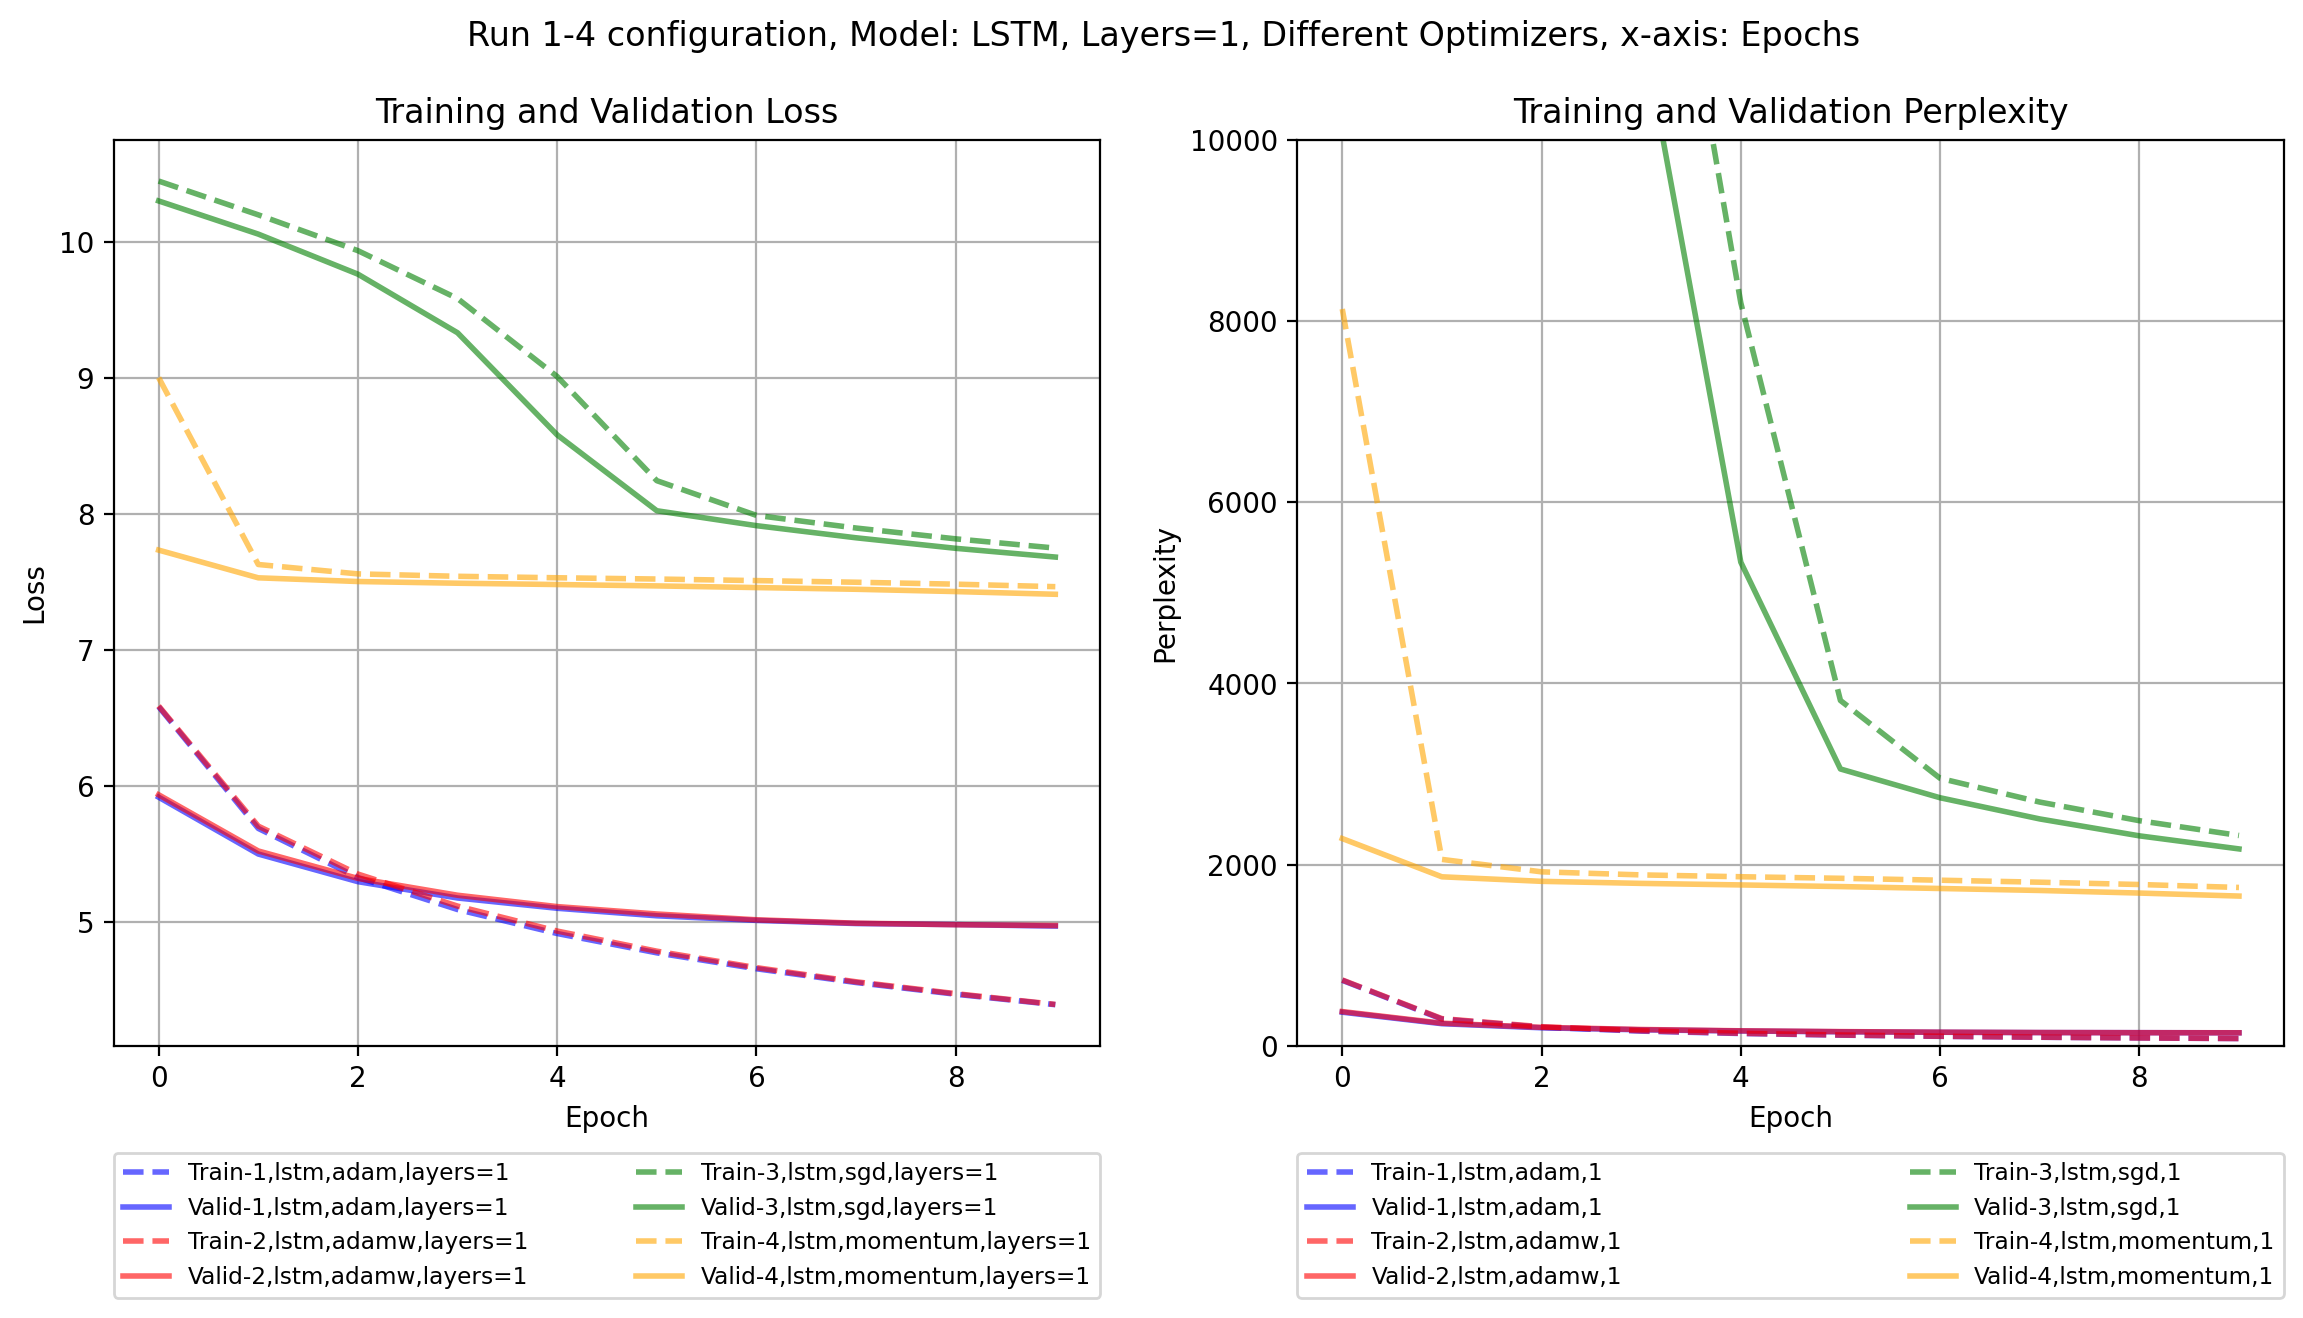

In [27]:
import pickle
import numpy as np

fig, axs = plt.subplots(1, 2, num=None, figsize=(14, 6), dpi=200, facecolor='w', edgecolor='k')

ax = axs[0]
counter = 0 

for run in runs[0:4]:

    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},layers={all_logs[run]['args']['layers']}"
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['train_loss']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['valid_loss']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True)
ax.set_title(f"Training and Validation Loss")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)



ax = axs[1]
counter = 0

for run in runs[0:4]:

    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},{all_logs[run]['args']['layers']}"
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['train_ppl']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['valid_ppl']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('Epoch')
ax.set_ylabel('Perplexity')
ax.set_ylim([0,10000])
ax.grid(True)
ax.set_title(f"Training and Validation Perplexity")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)

fig.suptitle('Run 1-4 configuration, Model: LSTM, Layers=1, Different Optimizers, x-axis: Epochs')


Text(0.5, 0.98, 'Run 5-6 configuration, Model: LSTM, Layers=2/4, Optimizer: AdamW, x-axis: Epochs')

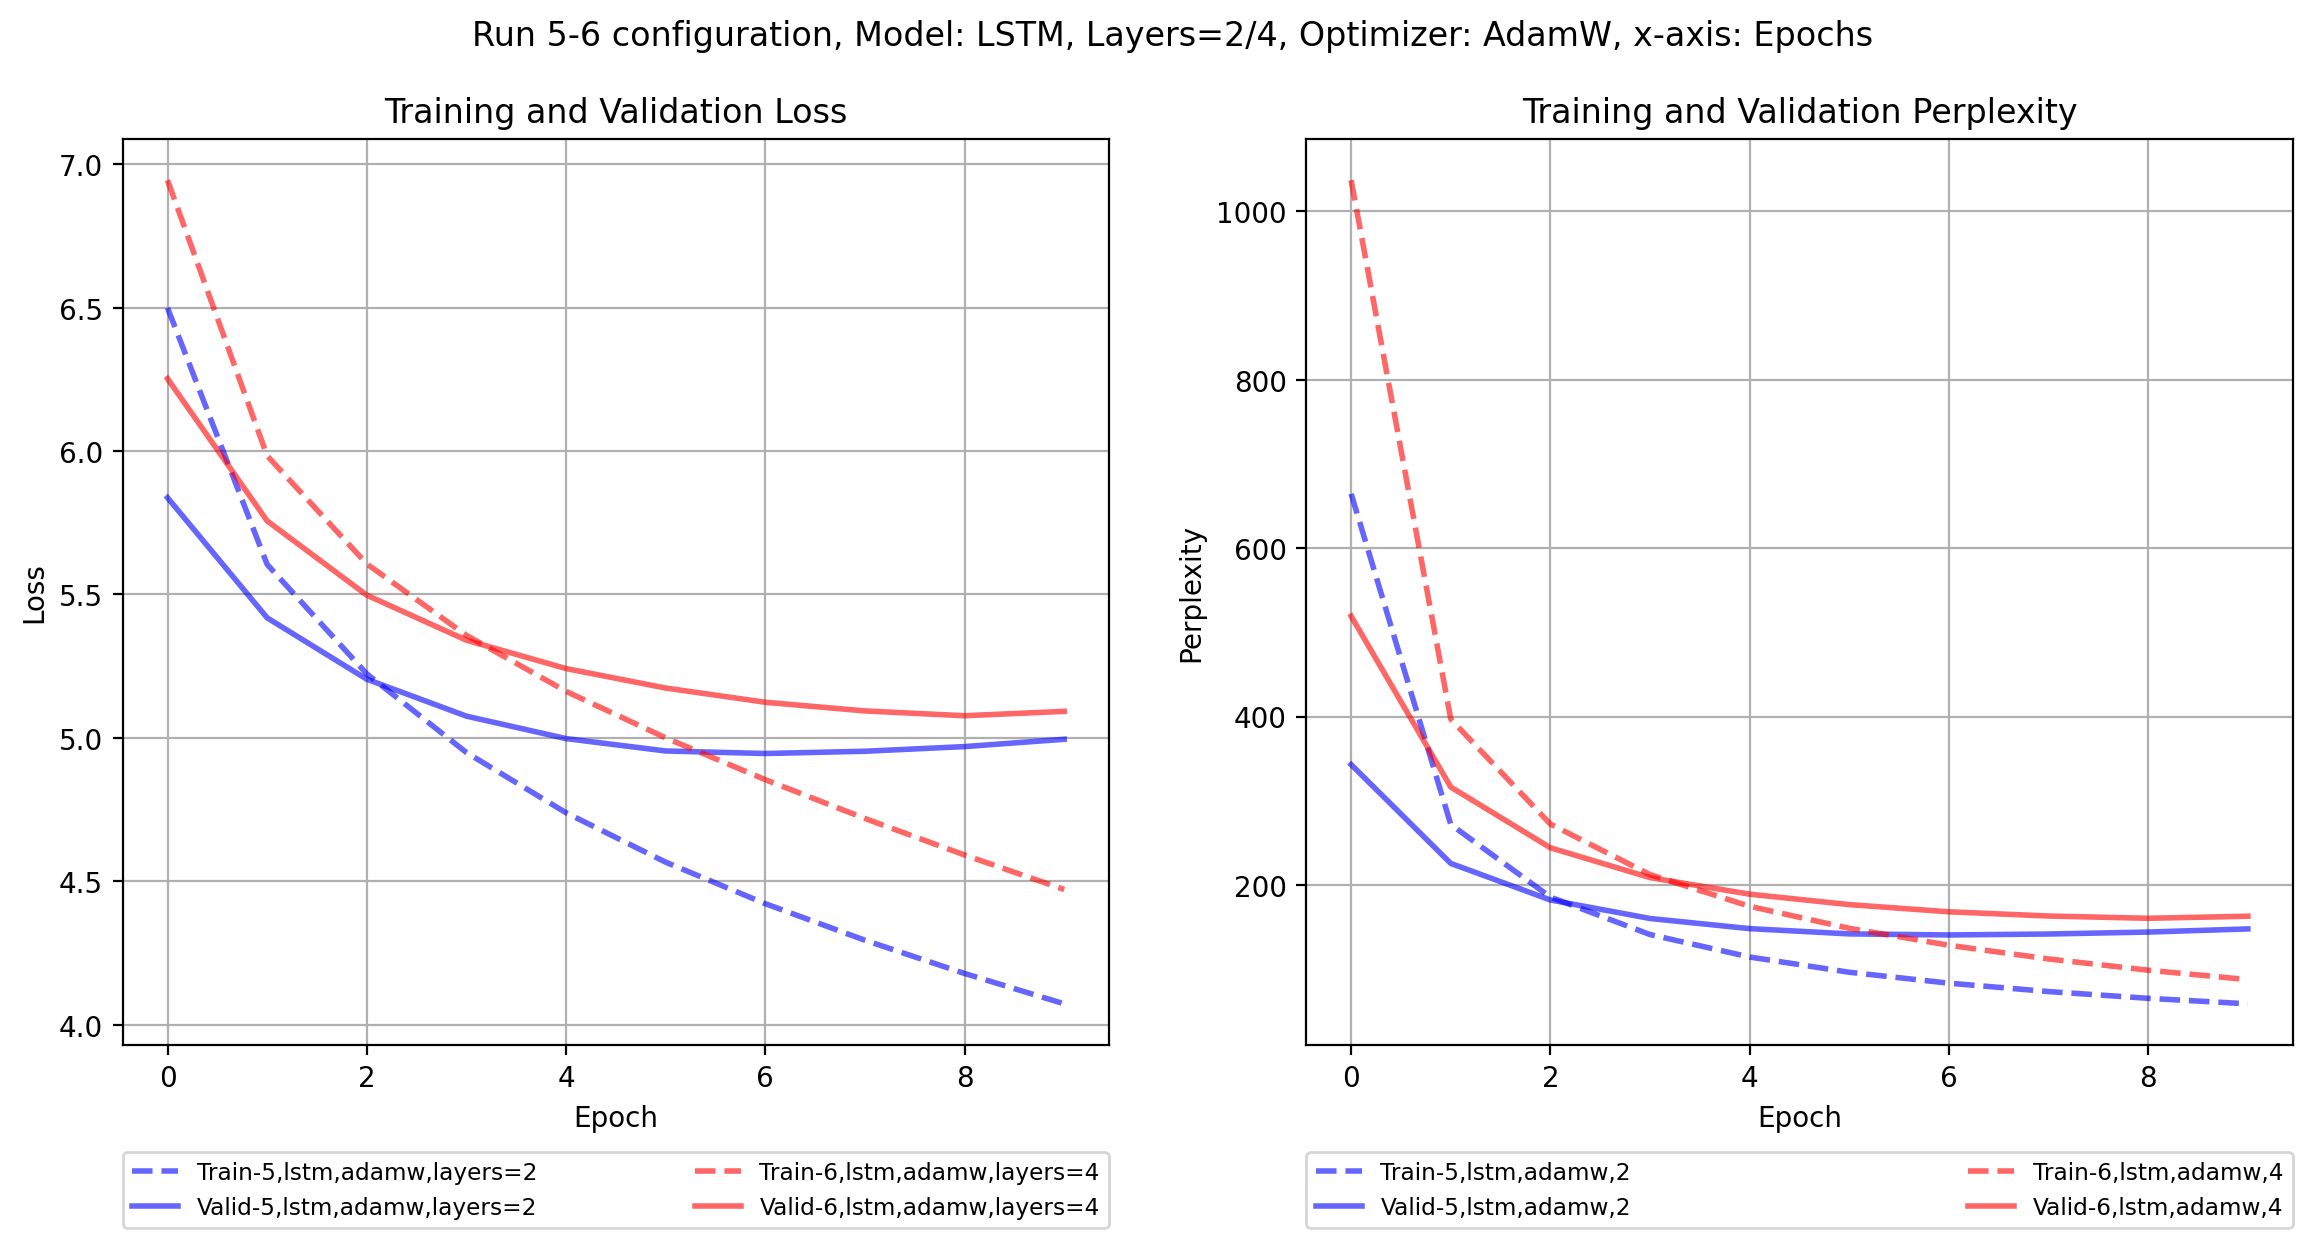

In [28]:
fig, axs = plt.subplots(1, 2, num=None, figsize=(14, 6), dpi=200, facecolor='w', edgecolor='k')

ax = axs[0]
counter = 0 

for run in runs[4:6]:
  
    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},layers={all_logs[run]['args']['layers']}"
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['train_loss']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['valid_loss']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True)
ax.set_title(f"Training and Validation Loss")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)



ax = axs[1]
counter = 0

for run in runs[4:6]:

  
    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},{all_logs[run]['args']['layers']}"
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['train_ppl']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['valid_ppl']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('Epoch')
ax.set_ylabel('Perplexity')
ax.grid(True)
ax.set_title(f"Training and Validation Perplexity")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)

fig.suptitle('Run 5-6 configuration, Model: LSTM, Layers=2/4, Optimizer: AdamW, x-axis: Epochs')


Similarly you can add and run the configs listed in 'run_exps_vit.py' for the problem 3

In [12]:
!python run_exp_vit.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer adam --exp_id="001" --log_dir="logs"

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.0
Initialized VIT model with 1086730 total parameters, of which 1086730 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.51484
[TRAIN] Epoch: 0, Iter: 100, Loss: 1.80669
[TRAIN] Epoch: 0, Iter: 200, Loss: 1.51107
[TRAIN] Epoch: 0, Iter: 300, Loss: 1.53371
== [TRAIN] Epoch: 0, Accuracy: 0.396 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.65394
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.472 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.68235
[TRAIN] Epoch: 1, Iter: 100, Loss: 1.46108
[TRAIN] Epoch: 1, Iter: 200, Loss: 1.39148
[TRAIN] Epoch: 1, Iter: 300, Loss: 1.38929
== [TRAIN] Epoch: 1, Accuracy: 0.500 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 1.52140
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.516 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 1.39305
[TRAIN] Epoch: 2, Iter: 100, Loss: 1.07387
[TRAIN] Epoch: 2, Iter: 200, Loss: 1.32873

In [13]:
!python run_exp_vit.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer adamw --exp_id="002" --log_dir="logs"

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.0
Initialized VIT model with 1086730 total parameters, of which 1086730 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.51484
[TRAIN] Epoch: 0, Iter: 100, Loss: 1.80669
[TRAIN] Epoch: 0, Iter: 200, Loss: 1.51108
[TRAIN] Epoch: 0, Iter: 300, Loss: 1.53370
== [TRAIN] Epoch: 0, Accuracy: 0.396 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.65393
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.473 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.68235
[TRAIN] Epoch: 1, Iter: 100, Loss: 1.46109
[TRAIN] Epoch: 1, Iter: 200, Loss: 1.39146
[TRAIN] Epoch: 1, Iter: 300, Loss: 1.38929
== [TRAIN] Epoch: 1, Accuracy: 0.500 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 1.52139
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.516 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 1.39301
[TRAIN] Epoch: 2, Iter: 100, Loss: 1.07393
[TRAIN] Epoch: 2, Iter: 200, Loss: 1.32877

In [14]:
!python run_exp_vit.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer sgd --exp_id="003" --log_dir="logs"

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.0
Initialized VIT model with 1086730 total parameters, of which 1086730 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.51484
[TRAIN] Epoch: 0, Iter: 100, Loss: 2.29169
[TRAIN] Epoch: 0, Iter: 200, Loss: 2.24205
[TRAIN] Epoch: 0, Iter: 300, Loss: 2.25822
== [TRAIN] Epoch: 0, Accuracy: 0.146 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 2.27797
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.187 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 2.26413
[TRAIN] Epoch: 1, Iter: 100, Loss: 2.25700
[TRAIN] Epoch: 1, Iter: 200, Loss: 2.21193
[TRAIN] Epoch: 1, Iter: 300, Loss: 2.22247
== [TRAIN] Epoch: 1, Accuracy: 0.196 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 2.25624
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.197 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 2.22282
[TRAIN] Epoch: 2, Iter: 100, Loss: 2.21074
[TRAIN] Epoch: 2, Iter: 200, Loss: 2.22440

In [15]:
!python run_exp_vit.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer momentum --exp_id="004" --log_dir="logs"

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.0
Initialized VIT model with 1086730 total parameters, of which 1086730 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.51484
[TRAIN] Epoch: 0, Iter: 100, Loss: 2.18139
[TRAIN] Epoch: 0, Iter: 200, Loss: 2.11911
[TRAIN] Epoch: 0, Iter: 300, Loss: 2.11934
== [TRAIN] Epoch: 0, Accuracy: 0.212 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 2.16418
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.253 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 2.12432
[TRAIN] Epoch: 1, Iter: 100, Loss: 2.05978
[TRAIN] Epoch: 1, Iter: 200, Loss: 1.96398
[TRAIN] Epoch: 1, Iter: 300, Loss: 2.00794
== [TRAIN] Epoch: 1, Accuracy: 0.274 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 2.08047
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.290 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 1.93921
[TRAIN] Epoch: 2, Iter: 100, Loss: 1.94319
[TRAIN] Epoch: 2, Iter: 200, Loss: 1.93611

In [16]:
!python run_exp_vit.py --model vit --layers 4 --batch_size 128 --epochs 10 --optimizer adamw --exp_id="005" --log_dir="logs"

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.0
Initialized VIT model with 2140938 total parameters, of which 2140938 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.50066
[TRAIN] Epoch: 0, Iter: 100, Loss: 1.73057
[TRAIN] Epoch: 0, Iter: 200, Loss: 1.52400
[TRAIN] Epoch: 0, Iter: 300, Loss: 1.47500
== [TRAIN] Epoch: 0, Accuracy: 0.403 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.58212
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.517 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.30802
[TRAIN] Epoch: 1, Iter: 100, Loss: 1.23680
[TRAIN] Epoch: 1, Iter: 200, Loss: 1.30677
[TRAIN] Epoch: 1, Iter: 300, Loss: 1.11646
== [TRAIN] Epoch: 1, Accuracy: 0.517 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 1.56014
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.540 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 1.20834
[TRAIN] Epoch: 2, Iter: 100, Loss: 1.19448
[TRAIN] Epoch: 2, Iter: 200, Loss: 1.21100

In [17]:
!python run_exp_vit.py --model vit --layers 6 --batch_size 128 --epochs 10 --optimizer adamw --exp_id="006" --log_dir="logs"

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.0
Initialized VIT model with 3195146 total parameters, of which 3195146 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35151
[TRAIN] Epoch: 0, Iter: 100, Loss: 1.61456
[TRAIN] Epoch: 0, Iter: 200, Loss: 1.67301
[TRAIN] Epoch: 0, Iter: 300, Loss: 1.44101
== [TRAIN] Epoch: 0, Accuracy: 0.409 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.62625
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.519 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.29066
[TRAIN] Epoch: 1, Iter: 100, Loss: 1.32952
[TRAIN] Epoch: 1, Iter: 200, Loss: 1.26909
[TRAIN] Epoch: 1, Iter: 300, Loss: 1.20793
== [TRAIN] Epoch: 1, Accuracy: 0.532 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 1.46304
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.561 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 1.19813
[TRAIN] Epoch: 2, Iter: 100, Loss: 1.27616
[TRAIN] Epoch: 2, Iter: 200, Loss: 1.25883

In [18]:
!python run_exp_vit.py --model vit --layers 6 --batch_size 128 --epochs 10 --optimizer adamw --block postnorm --exp_id="007" --log_dir="logs"

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.0
Initialized VIT model with 3195146 total parameters, of which 3195146 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35927
[TRAIN] Epoch: 0, Iter: 100, Loss: 1.68982
[TRAIN] Epoch: 0, Iter: 200, Loss: 1.67171
[TRAIN] Epoch: 0, Iter: 300, Loss: 1.44104
== [TRAIN] Epoch: 0, Accuracy: 0.392 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.57395
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.520 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.31786
[TRAIN] Epoch: 1, Iter: 100, Loss: 1.46248
[TRAIN] Epoch: 1, Iter: 200, Loss: 1.36219
[TRAIN] Epoch: 1, Iter: 300, Loss: 1.23736
== [TRAIN] Epoch: 1, Accuracy: 0.521 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 1.45420
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.544 ===>
====== Epoch 2 ======>
[TRAIN] Epoch: 2, Iter: 0, Loss: 1.32234
[TRAIN] Epoch: 2, Iter: 100, Loss: 1.23772
[TRAIN] Epoch: 2, Iter: 200, Loss: 1.30879

In [24]:
import numpy as np
import json

all_logs = dict.fromkeys(['001','002','003','004','005','006', '007'])
logs_dir = 'logs'

for run in all_logs.keys():
    all_logs[run] = dict.fromkeys(['train_accs','train_loss','train_time','valid_accs','valid_loss','valid_time','test_acc','test_loss','test_time'])
    logs = all_logs[run]

    
    for key in logs.keys():
        with open(f"./{logs_dir}/{run}/{key}.txt",'rb') as f:
            logs[key] = []
            for line in f.readlines():
                number = line.decode("utf-8").rstrip()
                logs[key].append(float(number))
    
    with open(f"./{logs_dir}/{run}/args.json",'rb') as f:
        args = json.load(f)
        logs['args'] = args


    wt_train = []
    wt_valid = []
    time = 0
    for idx in range(10):
        temp_time = logs['train_time'][idx]
        time = time + temp_time
        wt_train.append(time)
        time = time + logs['valid_time'][idx]
        wt_valid.append(time)

    logs['train_wtime'] = wt_train
    print(f"{run} train time:{logs['train_wtime'][-1]}")
    logs['valid_wtime'] = wt_valid
    

runs = list(all_logs.keys())
lw = 2
alpha=0.6

colors = ['blue', 'red', 'green', 'orange','brown','pink','yellow']

001 train time:464.6337025165558
002 train time:392.7502865791321
003 train time:383.4886648654938
004 train time:386.53388381004333
005 train time:508.62029910087585
006 train time:626.9126918315887
007 train time:610.7594056129456


Text(0.5, 0.98, 'Run 1-4 configuration, Model: ViT, Layers=2, Different Optimizers, x-axis: Epochs')

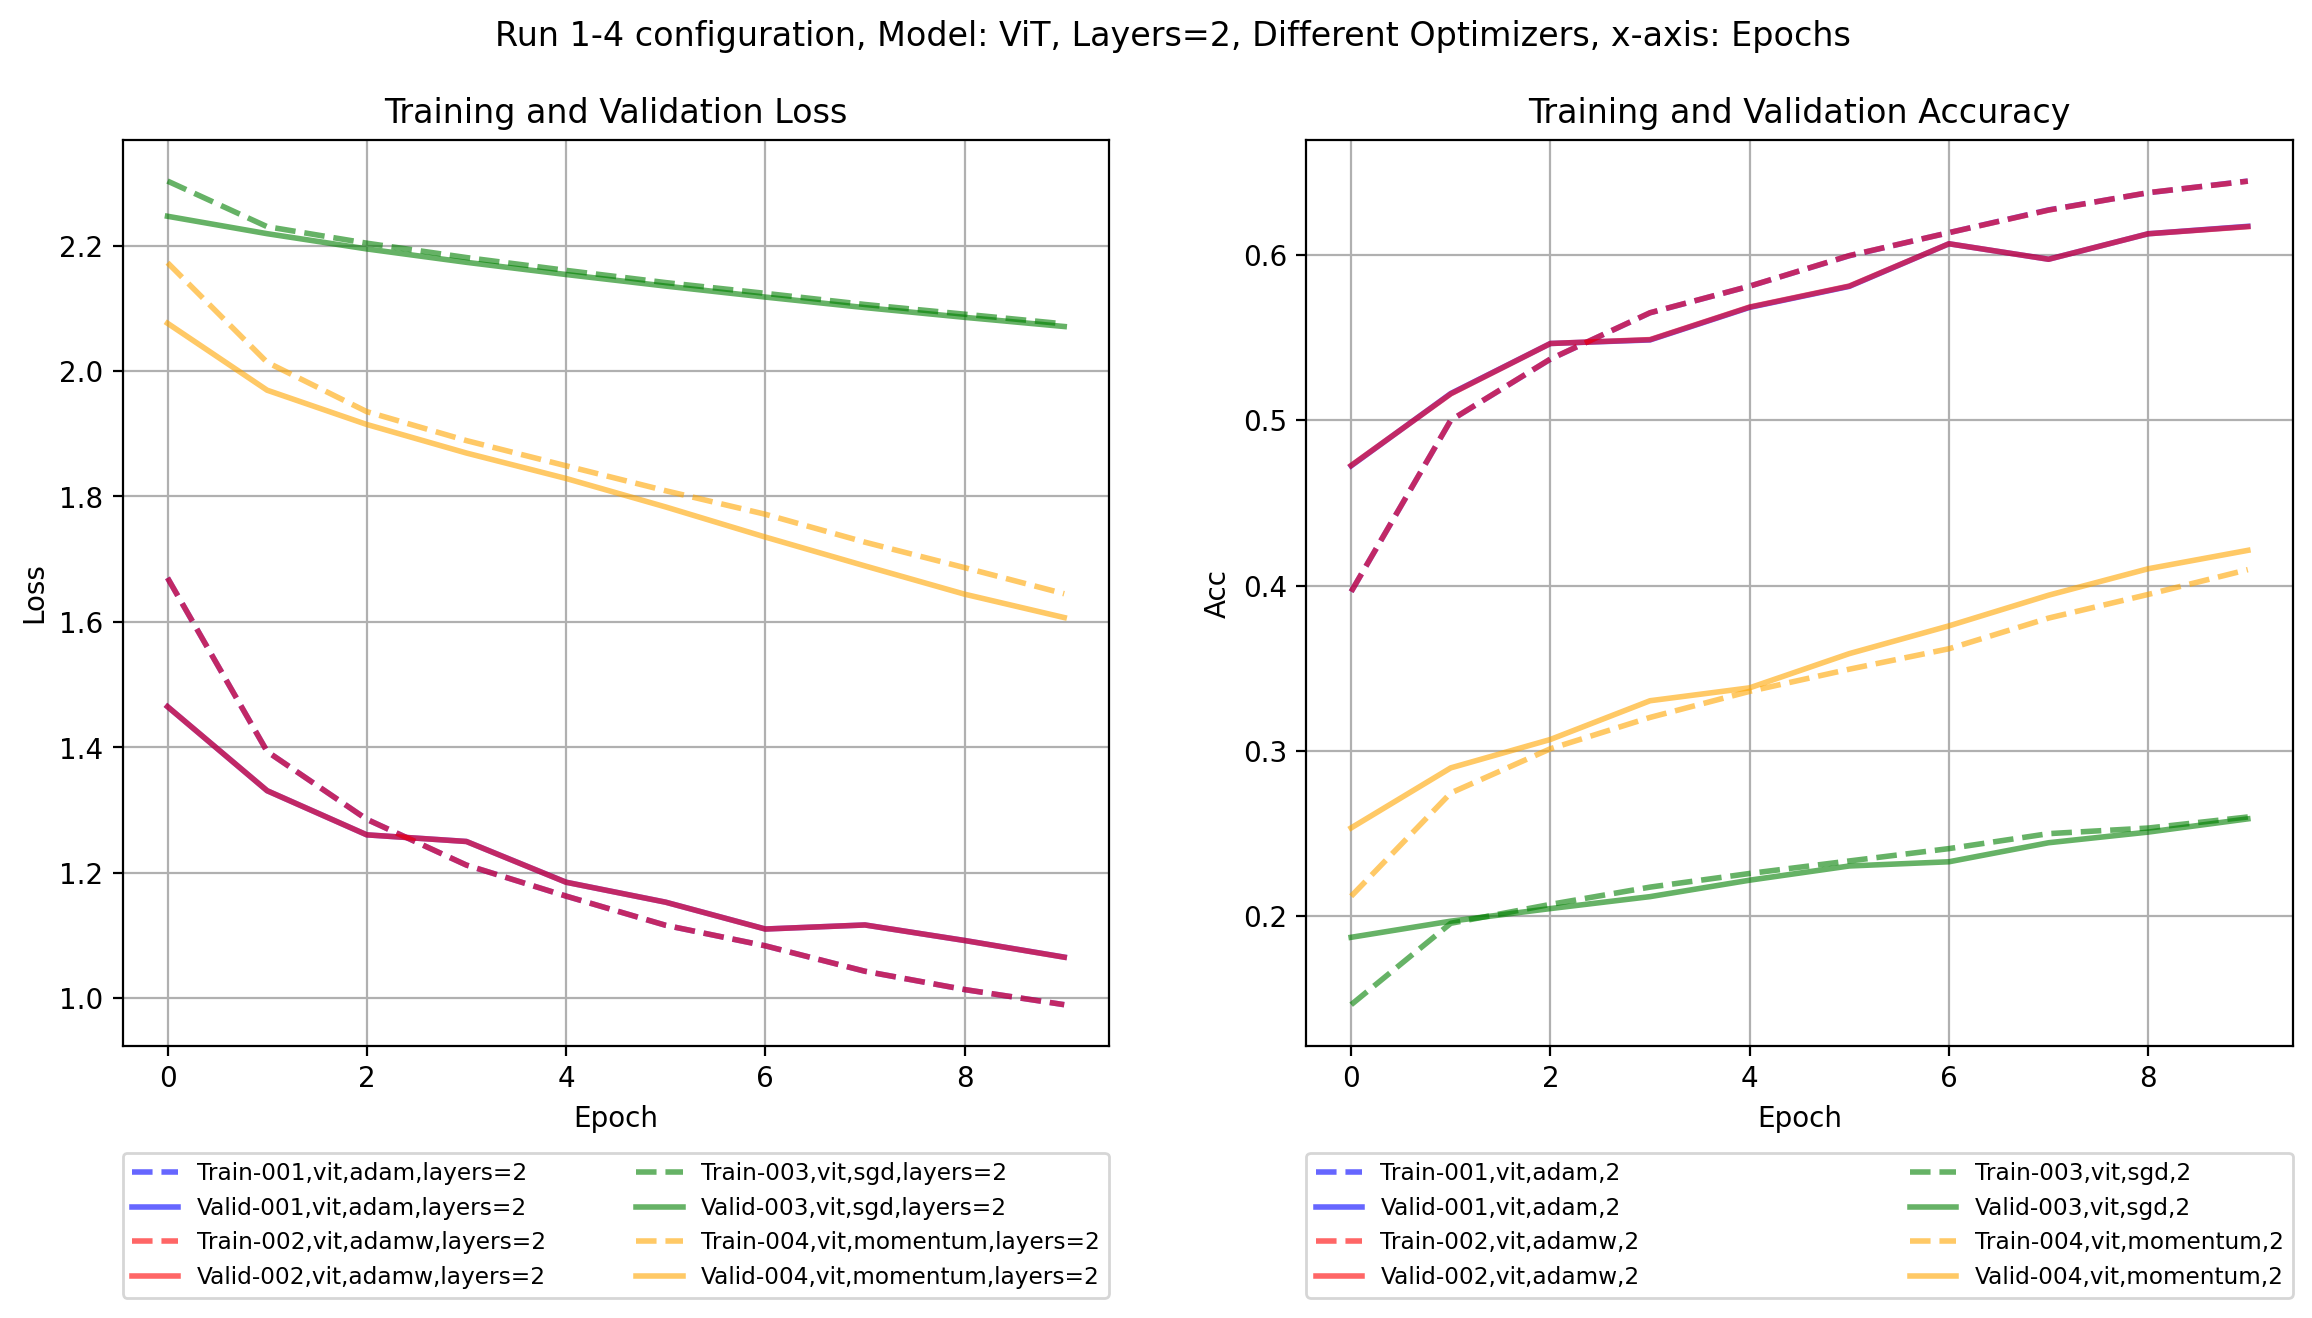

In [31]:
import pickle
import numpy as np

fig, axs = plt.subplots(1, 2, num=None, figsize=(14, 6), dpi=200, facecolor='w', edgecolor='k')

ax = axs[0]
counter = 0 

for run in runs[0:4]:

    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},layers={all_logs[run]['args']['layers']}"
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['train_loss']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['valid_loss']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True)
ax.set_title(f"Training and Validation Loss")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)



ax = axs[1]
counter = 0

for run in runs[0:4]:

    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},{all_logs[run]['args']['layers']}"
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['train_accs']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['valid_accs']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('Epoch')
ax.set_ylabel('Acc')
ax.grid(True)
ax.set_title(f"Training and Validation Accuracy")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)

fig.suptitle('Run 1-4 configuration, Model: ViT, Layers=2, Different Optimizers, x-axis: Epochs')


Text(0.5, 0.98, 'Run 1-4 configuration, Model: ViT, Layers=2, Different Optimizers, x-axis: Time')

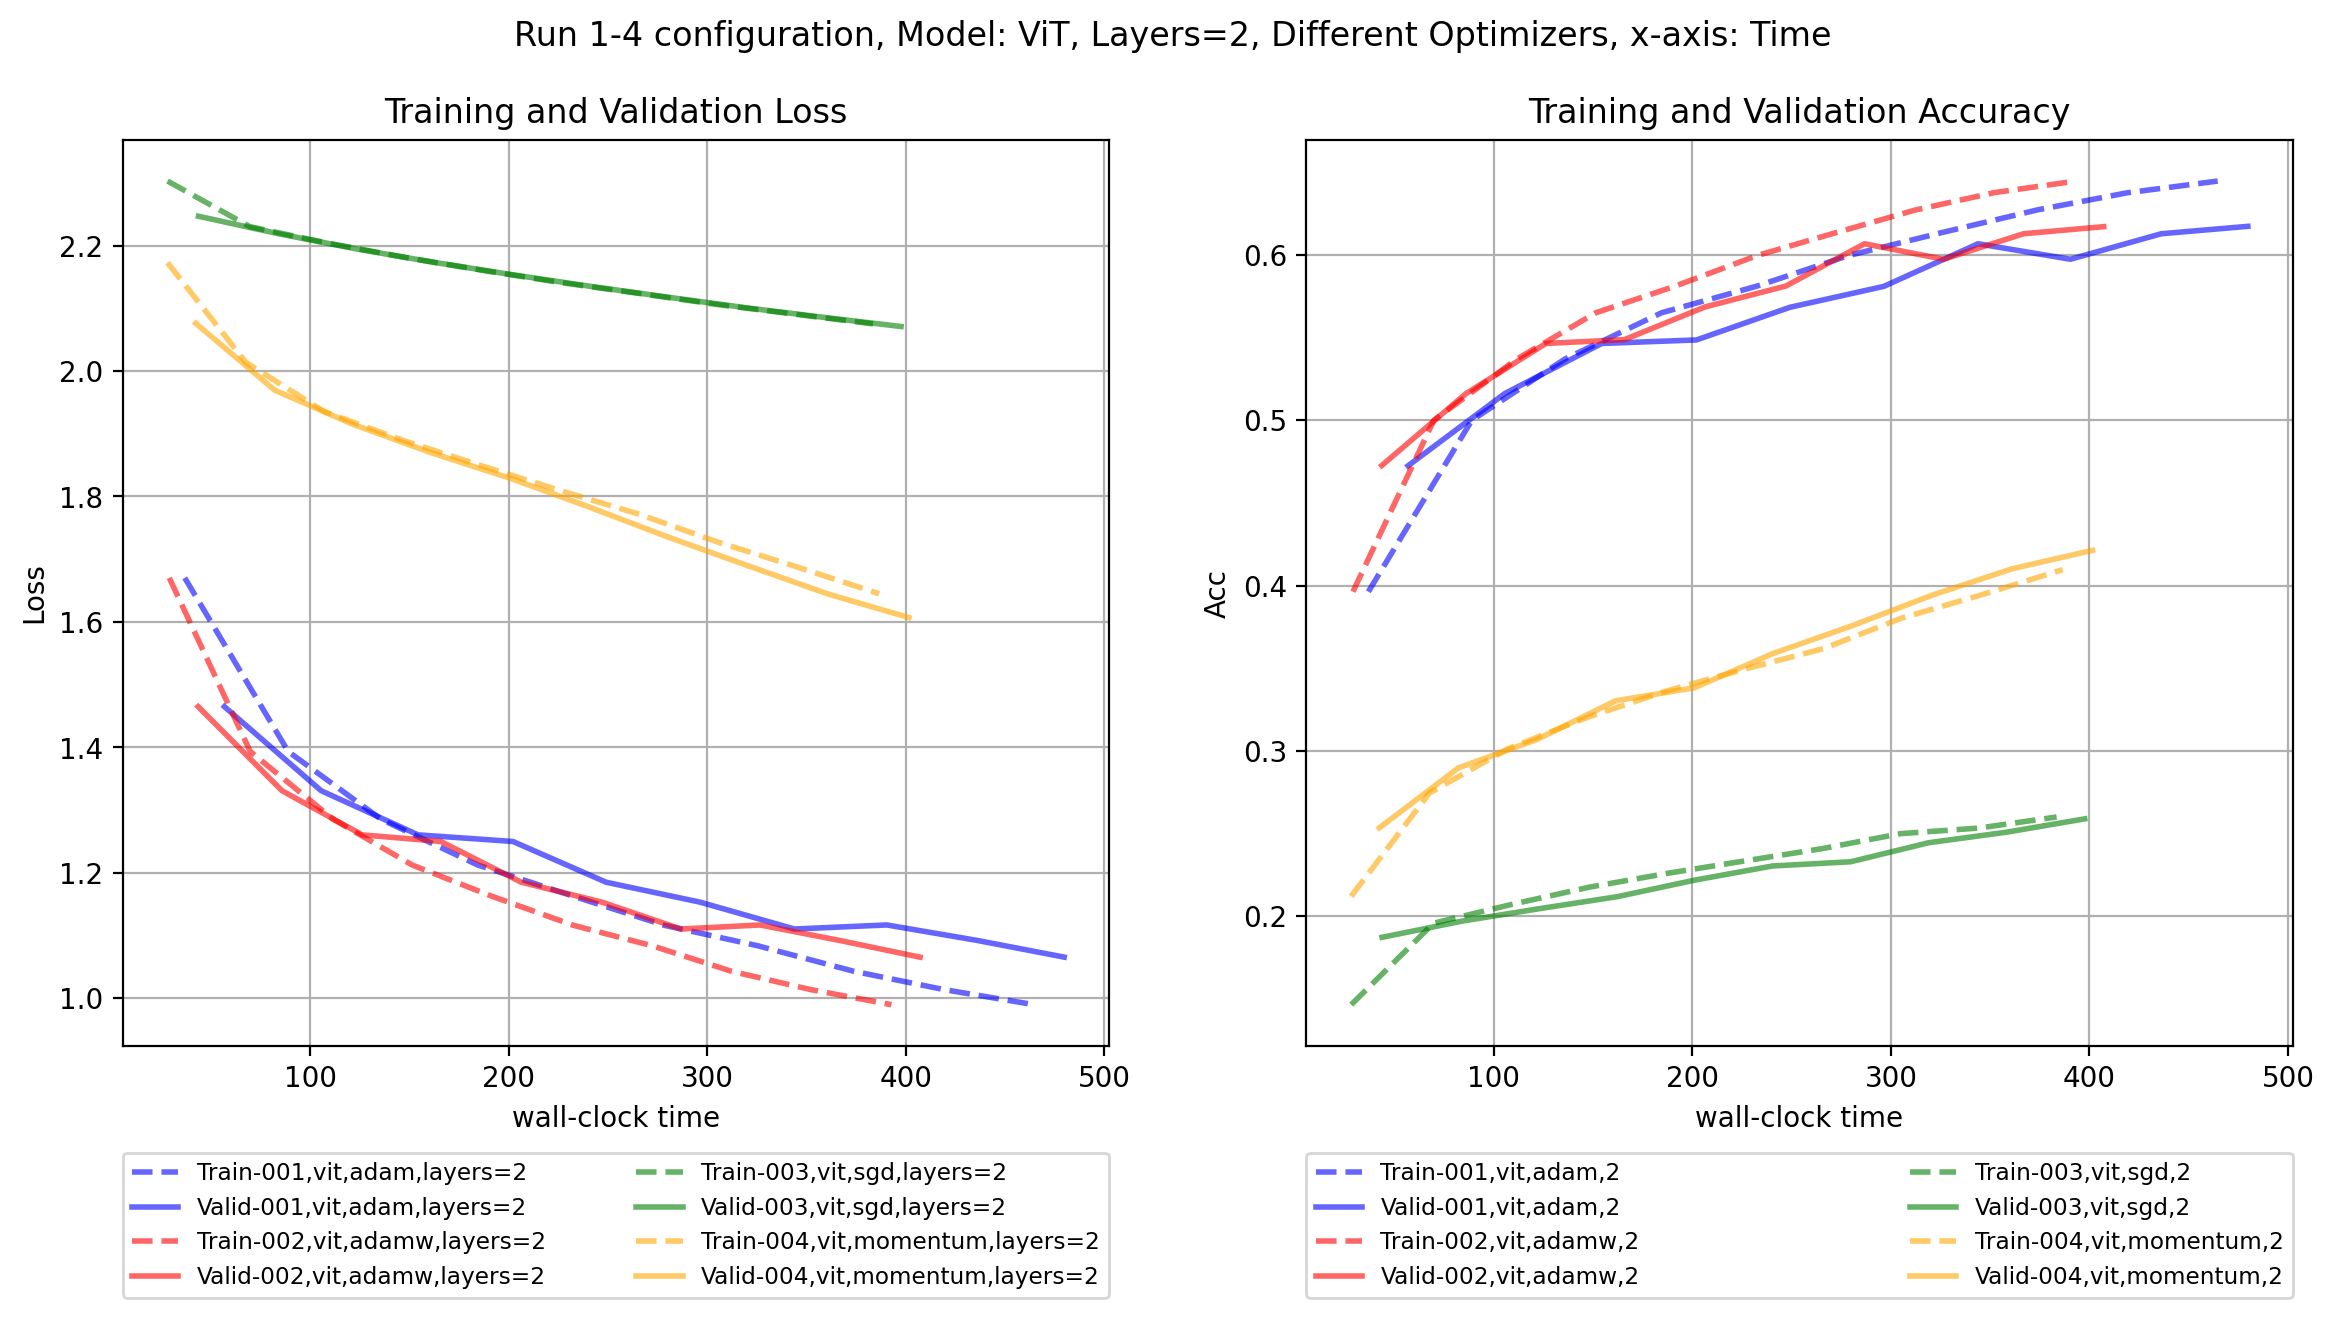

In [37]:
fig, axs = plt.subplots(1, 2, num=None, figsize=(14, 6), dpi=200, facecolor='w', edgecolor='k')

ax = axs[0]
counter = 0 

for run in runs[0:4]:

    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},layers={all_logs[run]['args']['layers']}"
    ax.plot(all_logs[run]['train_wtime'], np.array(all_logs[run]['train_loss']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(all_logs[run]['valid_wtime'], np.array(all_logs[run]['valid_loss']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('wall-clock time')
ax.set_ylabel('Loss')
ax.grid(True)
ax.set_title(f"Training and Validation Loss")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)



ax = axs[1]
counter = 0

for run in runs[0:4]:

    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},{all_logs[run]['args']['layers']}"
    ax.plot(all_logs[run]['train_wtime'], np.array(all_logs[run]['train_accs']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(all_logs[run]['valid_wtime'], np.array(all_logs[run]['valid_accs']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('wall-clock time')
ax.set_ylabel('Acc')
ax.grid(True)
ax.set_title(f"Training and Validation Accuracy")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)

fig.suptitle('Run 1-4 configuration, Model: ViT, Layers=2, Different Optimizers, x-axis: Time')

Text(0.5, 0.98, 'Run 4-7 configuration, Model: ViT, Layers=4/6, Different Optimizers, x-axis: Epochs')

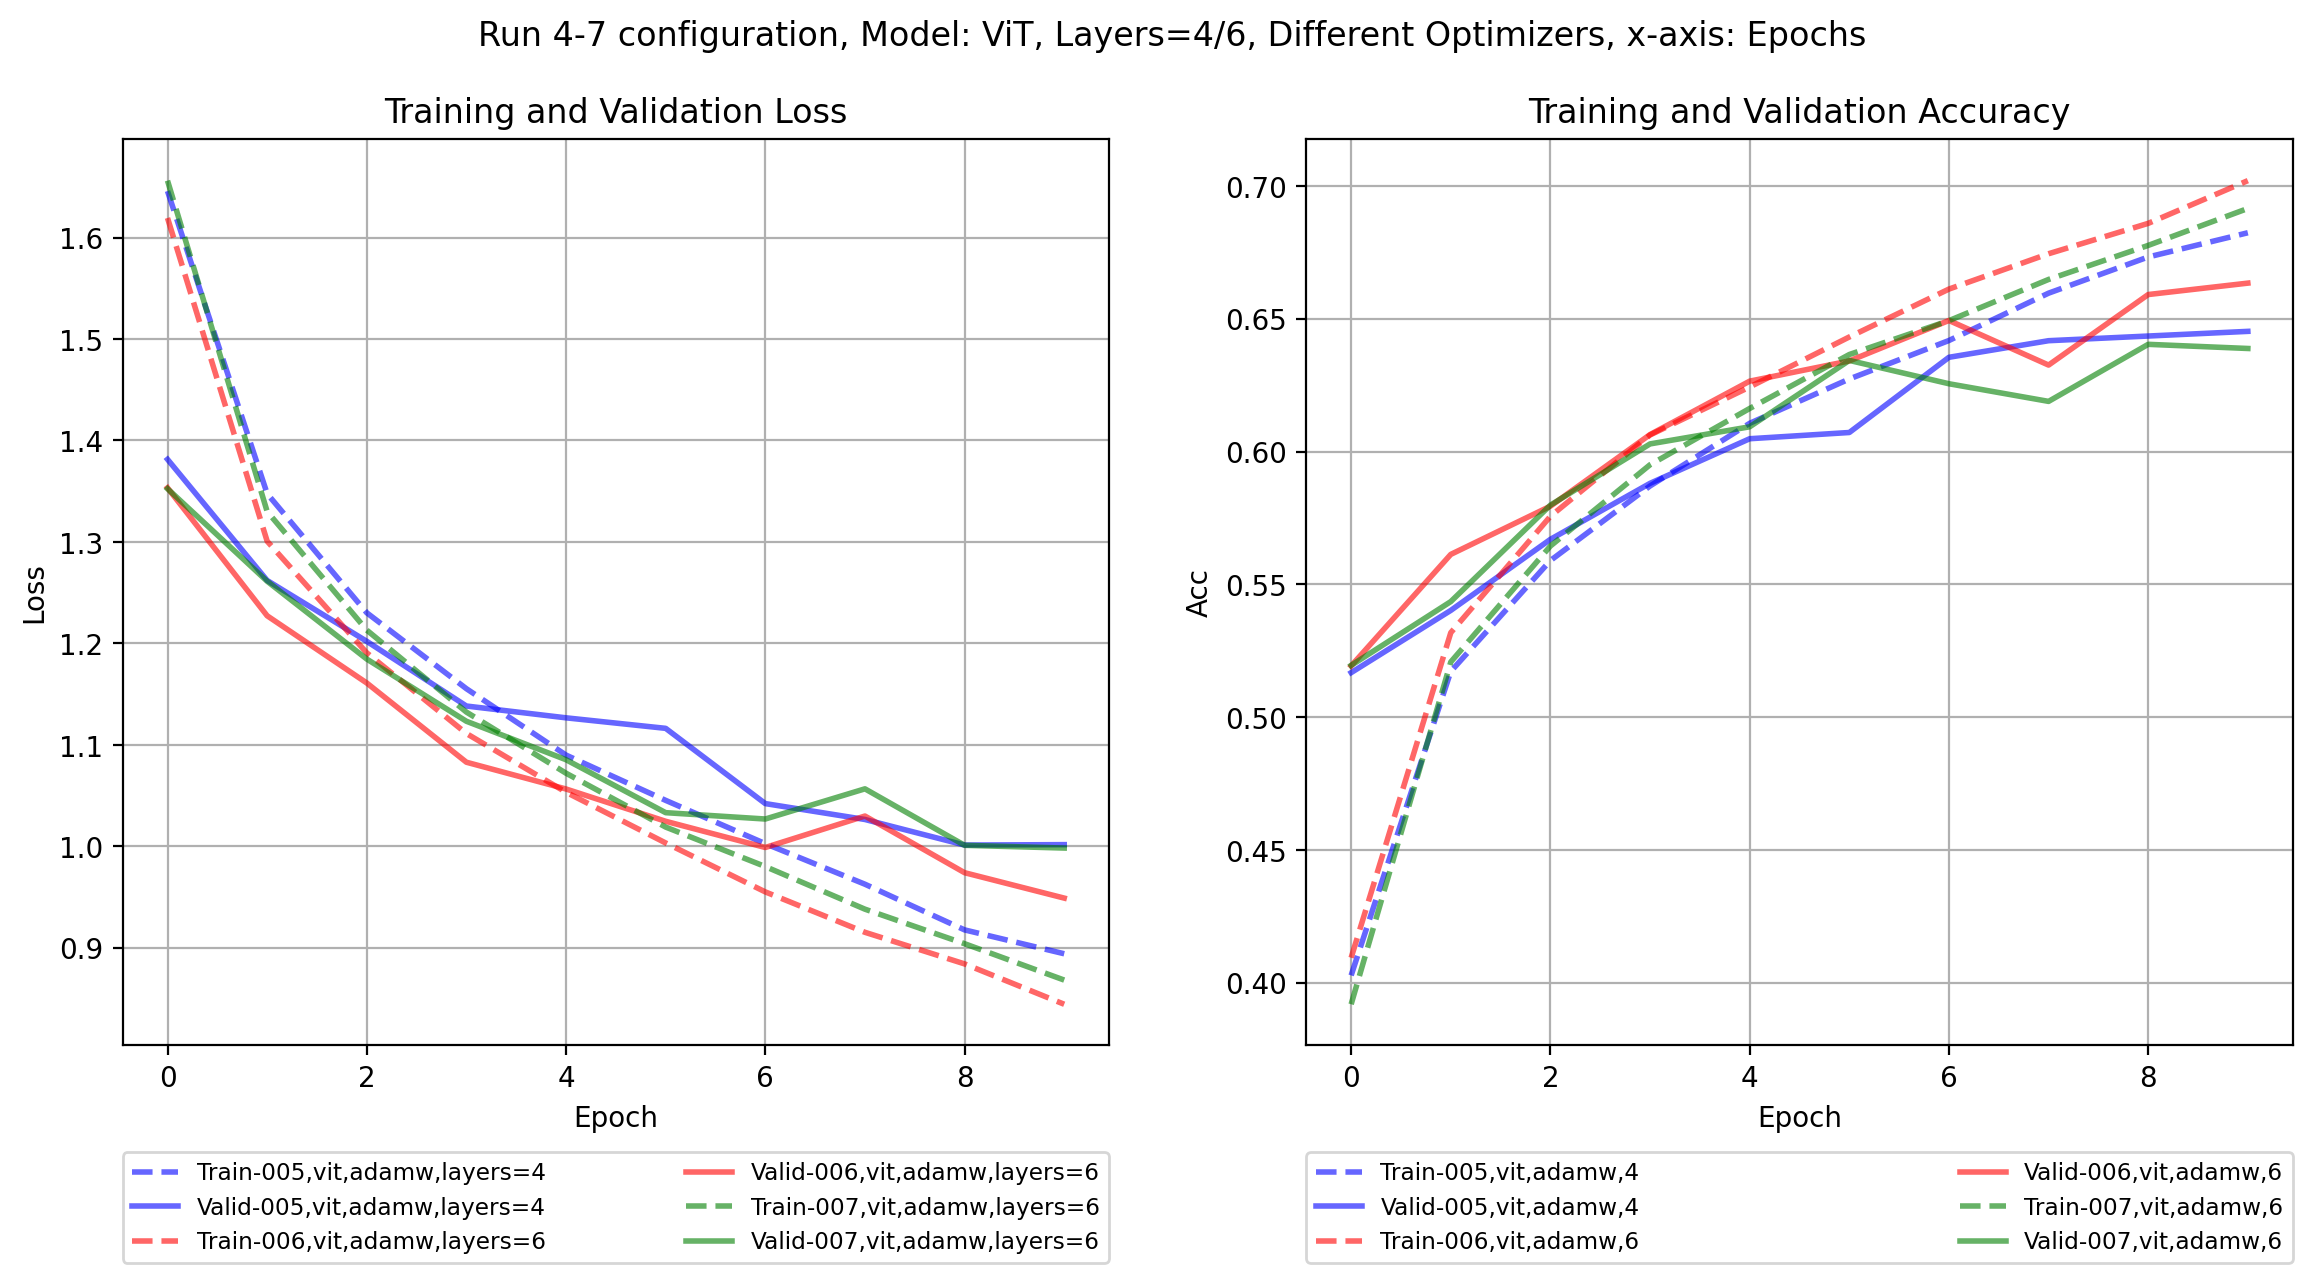

In [32]:
import pickle
import numpy as np

fig, axs = plt.subplots(1, 2, num=None, figsize=(14, 6), dpi=200, facecolor='w', edgecolor='k')

ax = axs[0]
counter = 0 

for run in runs[4:7]:

    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},layers={all_logs[run]['args']['layers']}"
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['train_loss']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['valid_loss']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True)
ax.set_title(f"Training and Validation Loss")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)



ax = axs[1]
counter = 0

for run in runs[4:7]:

    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},{all_logs[run]['args']['layers']}"
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['train_accs']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(np.arange(all_logs[run]['args']['epochs']), np.array(all_logs[run]['valid_accs']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('Epoch')
ax.set_ylabel('Acc')
ax.grid(True)
ax.set_title(f"Training and Validation Accuracy")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)

fig.suptitle('Run 4-7 configuration, Model: ViT, Layers=4/6, Different Optimizers, x-axis: Epochs')


Text(0.5, 0.98, 'Run 4-7 configuration, Model: ViT, Layers=2, Different Optimizers, x-axis: Time')

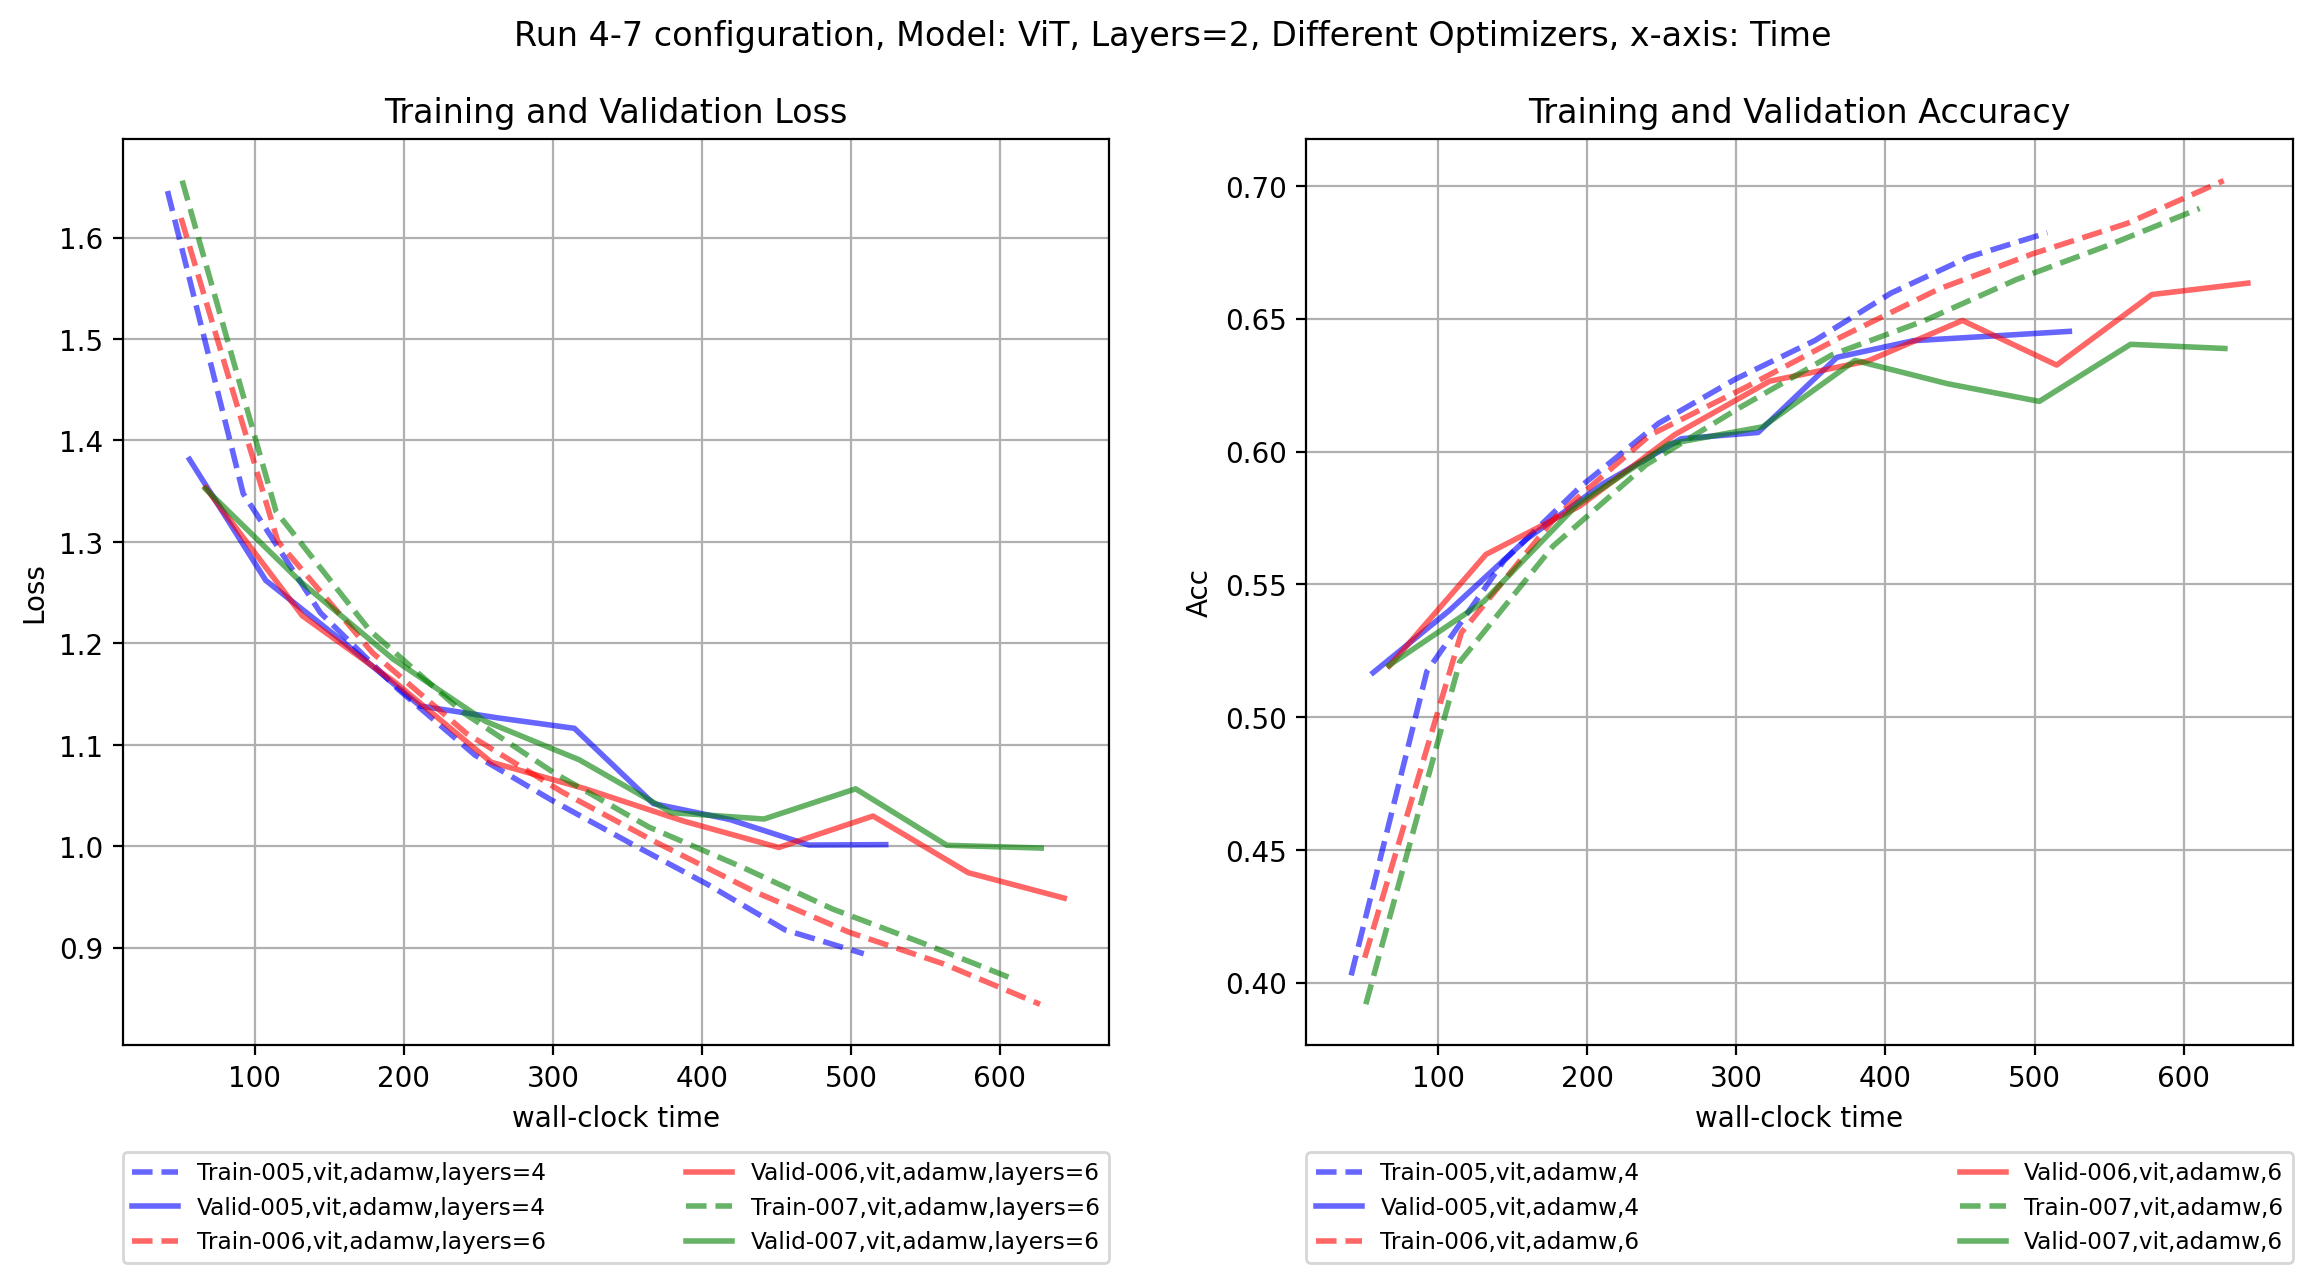

In [39]:
fig, axs = plt.subplots(1, 2, num=None, figsize=(14, 6), dpi=200, facecolor='w', edgecolor='k')

ax = axs[0]
counter = 0 

for run in runs[4:7]:

    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},layers={all_logs[run]['args']['layers']}"
    ax.plot(all_logs[run]['train_wtime'], np.array(all_logs[run]['train_loss']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(all_logs[run]['valid_wtime'], np.array(all_logs[run]['valid_loss']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('wall-clock time')
ax.set_ylabel('Loss')
ax.grid(True)
ax.set_title(f"Training and Validation Loss")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)



ax = axs[1]
counter = 0

for run in runs[4:7]:

    config = f"{all_logs[run]['args']['exp_id']},{all_logs[run]['args']['model']},{all_logs[run]['args']['optimizer']},{all_logs[run]['args']['layers']}"
    ax.plot(all_logs[run]['train_wtime'], np.array(all_logs[run]['train_accs']), label=f"Train-{config}", linewidth=lw, alpha=alpha, linestyle='dashed', color=colors[counter])
    ax.plot(all_logs[run]['valid_wtime'], np.array(all_logs[run]['valid_accs']), label=f"Valid-{config}", linewidth=lw, alpha=alpha, linestyle='solid', color=colors[counter])
    counter = np.mod(counter + 1,len(colors))

ax.set_xlabel('wall-clock time')
ax.set_ylabel('Acc')
ax.grid(True)
ax.set_title(f"Training and Validation Accuracy")
ax.legend(loc='best', bbox_to_anchor=(0., -0.22, 1., .102),
           ncol=2, mode="expand", fontsize='small', borderaxespad=0.)

fig.suptitle('Run 4-7 configuration, Model: ViT, Layers=2, Different Optimizers, x-axis: Time')

In [30]:
"""
# Configs to run
1. python run_exp.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer adam
2. python run_exp.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer adamw
3. python run_exp.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer sgd
4. python run_exp.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer momentum
5. python run_exp.py --model vit --layers 4 --batch_size 128 --epochs 10 --optimizer adamw
6. python run_exp.py --model vit --layers 6 --batch_size 128 --epochs 10 --optimizer adamw 
7. python run_exp.py --model vit --layers 6 --batch_size 128  --epochs 10 --optimizer adamw --block postnorm
"""

'\n# Configs to run\n1. python run_exp.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer adam\n2. python run_exp.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer adamw\n3. python run_exp.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer sgd\n4. python run_exp.py --model vit --layers 2 --batch_size 128 --epochs 10 --optimizer momentum\n5. python run_exp.py --model vit --layers 4 --batch_size 128 --epochs 10 --optimizer adamw\n6. python run_exp.py --model vit --layers 6 --batch_size 128 --epochs 10 --optimizer adamw \n7. python run_exp.py --model vit --layers 6 --batch_size 128  --epochs 10 --optimizer adamw --block postnorm\n'